In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans as k_means_sklearn
import time

## K-means - My implementation

In [2]:
class k_means(object):
    def __init__(self, n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 300, tol = 1e-4, verbose = False, random_state = None, copy_x = True, algorithm = 'auto', median_flag = False, vectorise = True):
        
        self.n_clusters = n_clusters #number of clusters to initialise
        self.init = init #'k-means++' selects initial clusters intelligently. 'random' chooses n_clusters rows at random
        self.n_init = n_init #Number of time the k-means algorithm will be run with different centroid seeds.
        self.max_iter = max_iter #max iterations for a single run
        self.tol = tol #Relative tolerance with regards to Frobenius norm of the difference in the cluster centers
        #of two consecutive iterations to declare convergence.
        self.verbose = verbose #If verbose = 1, print loss over iterations
        self.random_state = random_state #Determines random number generation for centroid initialisation
        self.copy_x = copy_x #Will not modify the original data, if False, data is centered and then uncentered
        self.algorithm = algorithm #EM or elkan
        self.median_flag = median_flag
        self.vectorise = vectorise #To try and vectorise the loops
        
        if random_state is not None:
            np.random.RandomState(self.random_state)
        
        #initialised parameters
        #self.cluster_centers_ = None #coordinates of cluster centers.
        #self.labels_ = None #labels of each point
        #self.inertia_ = None #sum of squared distances of samples to their closest center, weighted by sample weights if required
        self.inertia_train_ = None #List of inertia over the optimal run
        self.n_iter_ = None #Number of iterations runs
    
    def label_data(self, X):
        N = X.shape[0]
        labels = []
        
        if self.vectorise:
            mse_mat = np.zeros((N, self.n_clusters))
            
            for k in range(self.n_clusters):
                mse_mat[:, k] = np.sum((self.cluster_centers_[k, :] - X)**2, axis = 1)
            
            labels = np.argmin(mse_mat, axis = 1)
            
        else:
            for i in range(N):
                mse = np.sum((self.cluster_centers_ - X[i, :])**2, axis = 1)
                labels.append(np.argmin(mse))
        
        return np.array(labels)
    
    def compute_centroids(self, X):
        new_centers = np.zeros((self.n_clusters, X.shape[1]))
        
        #Already vectorised to some extent
        for k in range(self.n_clusters):
            label_indices = np.nonzero(self.labels_ == k)[0]
            
            if self.median_flag:
                new_centers[k, :] = np.median(X[label_indices, :], axis = 0)
            else:
                new_centers[k, :] = np.mean(X[label_indices, :], axis = 0)
                
        tol = np.linalg.norm(self.cluster_centers_ - new_centers)
        
        self.cluster_centers_ = new_centers

        return tol
        
    def calculate_inertia(self, X):
        
        J = 0
        
        for k in range(self.n_clusters):
            label_indices = np.nonzero(self.labels_ == k)[0]
            
            if self.vectorise:
                if self.median_flag:
                    J += np.sum(np.abs(self.cluster_centers_[k, :] - X[label_indices, :]))
                    
                else:
                    J +=np.sum((self.cluster_centers_[k, :] - X[label_indices, :])**2)
            
            else:
                for i in label_indices:

                    if self.median_flag:
                        J += np.sum(np.abs(self.cluster_centers_[k, :] - X[i, :]))
                    else:
                        J += np.sum((self.cluster_centers_[k, :] - X[i, :])**2)
        
        self.inertia_ = J
    
    def initialise_centroids(self, X):
        
        if self.init == 'k-means++':
            print("Initialisation not implemented.")
            raise SystemExit
        
        elif self.init == 'random':
            
            points = np.random.randint(0, X.shape[0], self.n_clusters)
            self.cluster_centers_ = X[points, :]
        
        else:
            print("Illegal initialisation.")
            raise SystemExit
    
    def standardise(self, X):
        self._mu_ = np.mean(X, axis = 0)
        self._std_ = np.std(X, axis = 0)
        
        return (X - self._mu_) / self._std_
    
    def unstandardise(self, X):
        
        return (X * self._std_) + self._mu_
        
    def fit(self, X, sample_weights = None, calculate_scores = True):
        
        if self.verbose:
            print("Beginning K-means...")
        
        #Check to see if you must standardise
        if not self.copy_x:
            X = self.standardise(X)
        
        #Initialise iteration dictionary
        iter_dict = {}
        
        #Initialise location properties
        optimal_inertia = np.inf
        optimal_outer = None
        
        for outer_iter in range(self.n_init):
            
            #initialise centroids
            self.initialise_centroids(X)
            
            #Calculate initial inertia
            self.labels_ = self.label_data(X)
            self.calculate_inertia(X)
            
            local_inertia_list = []
            
            tol = np.inf
            cnt = 0
            
            if self.verbose:
                print("\n Beginning outer iteration {}...".format(outer_iter))
            
            while cnt < self.max_iter and tol > self.tol:
                
                #E step
                self.labels_ = self.label_data(X)
                #print(self.labels_)
                
                #M step
                tol = self.compute_centroids(X)
                
                #Calculate loss
                self.calculate_inertia(X)
                
                #Finalise iteration
                local_inertia_list.append(self.inertia_)
                cnt += 1
                
                if self.verbose:
                    print("Outer iteration {}: inertia: {}".format(outer_iter, self.inertia_))
            
            iter_dict[str(outer_iter)] = {"centers":self.cluster_centers_,
                                          "labels":self.labels_,
                                          "loss_list":local_inertia_list,
                                          "n_iters":cnt}
            
            if optimal_inertia > self.inertia_:
                optimal_inertia = self.inertia_
                optimal_outer = outer_iter
                
        if self.verbose:
            print("\n Finished Training! Automatically selecting optimal centers...")
        
        #Load in optimal clusters
        self.cluster_centers_ = iter_dict[str(optimal_outer)]["centers"]
        
        #Label data
        self.labels_ = iter_dict[str(optimal_outer)]["labels"] #Will create a disjoint if it terminates early
        
        #Store loss list
        self.inertia_train_ = iter_dict[str(optimal_outer)]["loss_list"]
        
        #Store the iteration dict
        self.iter_dict = iter_dict
        
        #Check to see if you must un-standardise
        if not self.copy_x:
            X = self.unstandardise(X)
            self.cluster_centers = self.unstandardise(self.cluster_centers)
        
        if calculate_scores:
            if self.verbose:
                print("Calculating the Silhouette score...")

            #Calculate the silhouette score
            self.silhouette_score = self.Silhouette(X, self.labels_)
        
        return self
        
    
    def predict(self, X, sample_weight = None):
        labels = self.label_data(X)
        
        return labels
    
    def fit_predict(self, X, sample_weight = None, calculate_scores = True):
        self.fit(X, sample_weight, calculate_scores)
        labels = self.predict(X)
        
        return labels
    
    def fit_transform(self, X, sample_weights = None, calculate_scores = True):
        self.fit(X, sample_weights, calculate_scores)
        X_new = self.transform(X)
        
        return X_new
    
    def score(self, X, sample_weight = None):
        
        N, _ = X.shape
            
        min_distance = np.zeros(N)
        
        if self.vectorise:
            
            d_mat = np.zeros((N, self.n_clusters))
            
            for k in self.n_clusters:
                d_mat[:, k] = np.sqrt(np.sum((self.cluster_centers_[[k], :] - X)**2, axis = 1))
            
            min_distance = np.min(d_mat, axis = 1)
        
        else:
            for i in range(N):

                d_clusters = np.sqrt(np.sum((self.cluster_centers_ - X[i, :])**2, axis = 1))

                min_distance[i] = np.min(d_clusters)
        
        return min_distance
            
    
    def Silhouette(self, X, labels):
        
        N, f = X.shape
        
        #Create label nested lists
        classes = []

        for i in range(np.max(labels) + 1): #labels are zero padded
            indices = np.argwhere(labels == i)
            
            if len(indices) != 0:
                classes.append(indices[:, 0])           
        
        #Create distance matrix
        upper_indices_row, upper_indices_col = np.triu_indices(N)
        
        d_vals = []
        d_mat = np.zeros((N, N))
        
        for i,j in zip(upper_indices_row, upper_indices_col):
            
            if i == j:
                d_vals.append(0) #Distance is zero
            
            else:
                d_vals.append(np.sum((X[i, :] - X[j, :])**2) ** 0.5)
                
        d_mat[upper_indices_row, upper_indices_col] = d_vals
        
        d_mat = d_mat + d_mat.T - np.diag(np.diag(d_mat))
        
        S = np.zeros(N)
        
        for i in range(N):
            
            label_i = labels[i]
            C_I = len(classes[label_i])
            
            d_sum = []
            
            if C_I == 1:
                S[i] = 0
            
            else:
                for j in range(np.max(labels) + 1):

                    if j == label_i:
                        Ai = np.sum(d_mat[i, classes[j]]) / (C_I - 1)

                    else:
                        d_sum.append( np.mean(d_mat[i, classes[j]]) )

                #Calculate B
                Bi = np.min(d_sum)

                S[i] = (Bi - Ai) / max(Ai, Bi)

        return np.mean(S)

    def transform(self, X): #transform X to a cluster-distance space
        print("Transform is not implemented.")
        return None
    

## Random ball - class

In [3]:
class sample_random_balls(object):
    
    def __init__(self, n_centers, var_x = 1, var_y = 1, var_xy = 0, x_range = [-10, 10], y_range = [-10, 10], rotate = False):
        """
        Want to sample K blobs, with n_points per blob. Diversity range is controlled by x_range and y_range
        """
        
        self.n_centers = n_centers
        self.covariance = np.array([[var_x, var_xy], 
                                    [var_xy, var_y]])
        
        self.x_centers = np.random.random_sample(n_centers) * (x_range[1] - x_range[0]) + x_range[0]
        self.y_centers = np.random.random_sample(n_centers) * (y_range[1] - y_range[0]) + y_range[0]
        
        self.mu = np.vstack([self.x_centers, self.y_centers]).T
    
    def sample(self, n_points):
        #Find any real matrix A such that A.A^T = Cov. If Cov is positive definite, Cholesky decomposition can be used.
        #Alternatively, use spectral decomposition Cov = U.S.U^(-1) (A = U.sqrt(S)) (U is the eigenvector matrix)
        #Let z = (z_1, ..., z_n)^T be a vector whose components are N independent standard normal variables
        #let x = mu + Az.
        
        #Positive definite - x^T A x > 0 for all x (all eigenvalues are positive)
        #Positive semi-definite - x^T A x >= 0 for all x (all eigenvalues are non-negative)
        
        eig_vals, eig_vect = np.linalg.eig(self.covariance)
        
        if np.sum(eig_vals > 0) == 2:
            print("\nCovariance is positive definite.")
            
            A = np.linalg.cholesky(self.covariance)
            
        elif np.sum(eig_vals >= 0) == 2:
            print("\nCovariance is positive semi-definite.")
            
            A = np.dot(eig_vect, np.diag(np.sqrt(eig_vals)))
        
        
        point_samples = np.random.randint(low = 0, high = self.n_centers, size = n_points)
        
        z = np.random.randn(n_points, 2)
        x = self.mu[point_samples, :] + np.dot(A, z.T).T
        
        return x, point_samples

## Covariance plotter

In [4]:
def plot_ellipse(mean, covariance, X2_critical = 5.991, pca_method = True):
    
    if covariance.shape[0] == 2:
        
        t = np.linspace(0, 2 * np.pi, 1000)

        eig_vals, eig_vect = np.linalg.eig(covariance)

        pos_max = np.argmax(eig_vals)
        pos_min = np.abs(1 - pos_max)
    
        
        a = np.sqrt(X2_critical * eig_vals[pos_max])
        b = np.sqrt(X2_critical * eig_vals[pos_min])
        
        z = np.array([a * np.cos(t), b * np.sin(t)]).T

        
        if not pca_method:
            #Method 1
            alpha = np.arctan(eig_vect[1, pos_max] / eig_vect[0, pos_max])# - np.pi/2
            
            R = np.array([[np.cos(alpha), -np.sin(alpha)],
                          [np.sin(alpha), np.cos(alpha)]])

            #x = R . z
            #x.T = z . R.T
            X = np.dot(z, R.T)
        else:
            #Method 2
            #Basically performing reverse of PCA, generate data in Z space, project back using eigenvectors
            ordered_eig_vect = eig_vect[:, [pos_max, pos_min]] #Rotate using Eigenvectors!
            
            #x = U * z
            #x.T = z . U.T
            X = np.dot(z, ordered_eig_vect.T)
        
        return mean + X

## GMM class

In [5]:
class gaussian_mixture_models(object):
    def __init__(self, n_components, covariance_type = 'full', tol = 0.001, reg_covar = 1e-3, max_iter = 100, n_init = 1, init_params = 'kmeans', use_sklearn = False, random_state = None, warm_start = False, verbose = False, verbose_interval = 10, vectorise = True):
        
        self.n_components = n_components
        self.covariance_type = covariance_type #full, tied, diag, spherical
        self.tol = tol #convergence threshold, stops when lower bound avg gain is below threshold
        self.reg_covar = reg_covar #Non-negative regularisation added to the diagonal of covariance. Ensures cov is positive
        self.max_iter = max_iter #Number of EM iterations
        self.n_init = n_init #Number of initialisations to perform
        self.init_params = init_params #'k-means' or 'random' - specifies how to initialise means and covariances
        self.use_sklearn = use_sklearn
        self.random_state = random_state #controls the random seed to initialise the parameters of the model
        self.warm_start = warm_start #if True, solution of last fitting is used to initialise the next run
        self.verbose = verbose #Controls what you print
        self.verbose_interval = verbose_interval #Intervals between prints
        self.vectorise = vectorise #Controls if you want to use loops or matrices to calculate x^T A x operations
        
        #Attributes
        #self.weights_ = None #Mixture weights #(n_components,)
        #self.means_ = None #Mixture means (n_components, n_features)
        #self.covariances = None #Mixture covariances
        # spherical: (n_components, )
        # diagonal: (n_components, n_features)
        # tied: (n_features, n_features)
        # full: (n_components, n_features, n_features)
        #self.converged_ = False #Flag to tell if the model converged
        #self.n_iter_ = None #Number of steps to finalise run
        #self.lower_bound_ = None #lower bound value of the log-likelihood (training data wrt model for best fit model)
        #self.n_features_in_ = None #number of features seen during fit
    
    def set_params(self, X):
        
        Ntotal, self.n_features_in_ = X.shape
        
        if not hasattr(self, "mix_init_") or not hasattr(self, "mu_init_") or not hasattr(self, "cov_init_"):
        
            #Initialise weight (mixing coeffient) vector
            mix_init = np.zeros((self.n_components,))

            #Initialise mean matrix
            mu_init = np.zeros((self.n_components, self.n_features_in_))

            #Initialise covariance matrix
            if self.covariance_type == 'spherical':
                cov_init = np.zeros((self.n_components,))

            elif self.covariance_type == 'diagonal':
                cov_init = np.zeros((self.n_components, self.n_features_in_))

            elif self.covariance_type == 'tied':
                cov_init = np.zeros((self.n_features_in_, self.n_features_in_))

            elif self.covariance_type == 'full':
                cov_init = np.zeros((self.n_components, self.n_features_in_, self.n_features_in_))

            else:
                print("Incompatible covariance_type entered.")
                raise SystemExit

            if self.init_params == 'kmeans':

                if self.verbose:
                    print("\nRunning k-means to initialise model parameters...")

                if self.use_sklearn:
                    self.k_means_local = k_means_sklearn(self.n_components, 
                                                         random_state = self.random_state, 
                                                         verbose = self.verbose)

                    label = self.k_means_local.fit_predict(X)

                else:
                    self.k_means_local = k_means(self.n_components, 
                                                 'random', 
                                                 random_state = self.random_state, 
                                                 verbose = self.verbose,
                                                 vectorise = True)

                    label = self.k_means_local.fit_predict(X, calculate_scores = False)

                if self.verbose:
                    print("\nFinished k-means")

                for i in range(self.n_components):
                    label_indices = np.nonzero(label == i)[0]

                    x_cluster = X[label_indices, :]
                    N = len(label_indices)

                    #Update mixing matrix
                    mix_init[i] = len(label_indices) / Ntotal

                    #Save mean
                    mu_init[i, :] = np.mean(x_cluster, axis = 0)

                    #Calculate standard covariance
                    z = x_cluster - mu_init[i, :]
                    covariance_cluster = 1/(N - 1) * np.dot(z.T, z)

                    #Add in regularisation term
                    covariance_cluster += np.eye(self.n_features_in_) * self.reg_covar

                    if self.covariance_type == 'spherical':
                        cov_init[i] = np.mean(np.diag(covariance_cluster))

                    elif self.covariance_type == 'diagonal':
                        cov_init[i, :] = np.diag(covariance_cluster)

                    elif self.covariance_type == 'tied':
                        cov_init += covariance_cluster

                    elif self.covariance_type == 'full':
                        cov_init[i, :, :] = covariance_cluster

                if self.covariance_type == 'tied':
                    cov_init /= self.n_components #Average covariance matrix


            elif self.init_params == 'random':
                print("'random' init_params initialisation not implemented.")
                raise SystemExit

            else:
                print("Incompatible init_params entered.")
                raise SystemExit

            #original initialisations
            self.mix_init_ = mix_init
            self.mu_init_ = mu_init
            self.cov_init_ = cov_init
        
        #Save matrices
        self.weights_ = self.mix_init_
        self.means_ = self.mu_init_
        self.covariances_ = self.cov_init_
        
        
    
    def get_params(self):
        
        #returns covariances as a k x D x D matrix, regardless of type
        
        covariance = np.zeros((self.n_components, self.n_features_in_, self.n_features_in_))
        
        for k in range(self.n_components):
            if self.covariance_type == 'spherical':
                    covariance[k, :, :] = np.diag(self.covariances_[k] * np.ones(self.n_features_in_))

            elif self.covariance_type == 'diagonal':
                covariance[k, :, :] = np.diag(self.covariances_[k, :])

            elif self.covariance_type == 'tied':
                covariance[k, :, :] = self.covariances_

            elif self.covariance_type == 'full':
                covariance[k, :, :] = self.covariances_[k, :, :]
        
        return self.weights_, self.means_, covariance
    
    def evaluate_gauss(self, x, mu, covariance):
        #All vector/matrix inputs (so that shape is fine)
        #You could also store the precisions, may make this evaluation faster
        
        precision = np.linalg.inv(covariance) #Sorry prof. Kok
        
        if self.vectorise:
            D = x.shape[1]
            z = x - mu.reshape(1, -1) #reshape mu
            
            second_part = np.exp((-1 / 2) * np.sum(np.dot(z, precision) * z, axis = 1))
        
        else: #vector inputs for mu and x_vec
            D = x.shape[0]
            z = x - mu
        
            second_part = np.exp((-1 / 2) * np.dot(z.T, np.linalg.solve(covariance, z)))
            
        first_part = 1 / ((2 * np.pi)**(D / 2))  * 1 / (np.linalg.det(covariance)**(1/2))
        
        return first_part * second_part
    
    def evaluate_log_gauss(self, x, mu, covariance):
        #All vector/matrix inputs (so that shape is fine)
        #You could also store the precisions, may make this evaluation faster
        
        precision = np.linalg.inv(covariance) #Sorry prof. Kok
        
        if self.vectorise:
            D = x.shape[1]
            z = x - mu.reshape(1, -1)
            
            third_part = -1/2 * np.sum(np.dot(z, precision) * z, axis = 1)
        
        else:     
            D = x.shape[0]
            z = x - mu
            third_part = -1/2 * np.dot(z.T, np.linalg.solve(covariance, z))

        first_part = -D/2 * np.log(2 * np.pi)
        second_part = -1/2 * np.log(np.linalg.det(covariance))
        
        return first_part + second_part + third_part
    
    def data_likelihood(self, x): #p(x)
        
        #use log-sum-exp to ensure that you do not hit numerical underflow!
        mix, mu, cov = self.get_params()
        
        if self.vectorise:
            N = x.shape[0]
        
        else:
            N = 1
        
        log_likelihoods = np.zeros((N, self.n_components))
        
        for k in range(self.n_components):
            
            mean_vec = mu[[k], :].T #N x 1 vector
            cov_mat = cov[k, :, :] #N x N matrix

            if self.vectorise:
                log_likelihoods[:, k] = self.evaluate_log_gauss(x, mean_vec, cov_mat) + np.log(mix[k])
                
            else:
                log_likelihoods[0, k] = self.evaluate_log_gauss(x, mean_vec, cov_mat) + np.log(mix[k])

        #Apply log-sum-exp trick
        A = np.max(log_likelihoods, axis = 1, keepdims=True)
    
        log_likelihood_sum = A + np.log(np.sum(np.exp(log_likelihoods - A), axis = 1, keepdims = True))
        
        p_x = np.exp(log_likelihood_sum)
        
        return p_x, log_likelihoods, log_likelihood_sum
    
    def posterior_likelihood(self, x): #Calculates the responsibilities 
        
        _, log_likelihoods, log_likelihood_sum = self.data_likelihood(x)
        
        responsibility = np.exp(log_likelihoods - log_likelihood_sum)
        
        return responsibility
    
    def log_likelihood(self, X, sum_flag = True): #return the log-likelihood sum
        
        N = X.shape[0]
        
        mix, mu, cov = self.get_params()
        LL = np.zeros((N, 1))
        
        if self.vectorise:
            LL = self.data_likelihood(X)[2]
        
        else:
            for i in range(N):

                x_vec = X[[i], :].T #N x 1 vector

                #Add log-likelihood
                LL[i, 0] = self.data_likelihood(x_vec)[2]
        
        if sum_flag:
            return np.mean(LL)
        
        else:
            return LL
    
    def Nk(self, X):
        N = X.shape[0]
        
        resp_mat = np.zeros((N, self.n_components))
        
        if self.vectorise:
            resp_mat[:, :] = self.posterior_likelihood(X)
        
        else:
            for i in range(N):
                resp_mat[i, :] = self.posterior_likelihood(X[[i], :].T)
        
        N_vec = np.sum(resp_mat, axis = 0)
        
        return N_vec, resp_mat
    
    def update_mu(self, X, resp_mat, N_vec):
        
        mu_new = np.zeros_like(self.means_)
        
        for i in range(self.n_components):
            mu_new[i, :] = np.sum(resp_mat[:, [i]] * X, axis = 0) / N_vec[i]
        
        self.means_ = mu_new
    
    def update_covar(self, X, resp_mat, N_vec):
        
        N, D = X.shape
        cov_mat = np.zeros_like(self.covariances_)
        
        if self.covariance_type == 'spherical':
            
            for k in range(self.n_components):
                
                placeholder_cov = np.zeros((1, 1))
                
                if self.vectorise:
                    z = X - self.means_[[k], :]
                    
                    placeholder_cov[0, 0] = np.sum(resp_mat[:, [k]] * z**2)
                
                else:
                    for n in range(N):
                        z = np.transpose(X[[n], :] - self.means_[[k], :])

                        placeholder_cov += resp_mat[n, k] * np.dot(z.T, z)
                
                #Normalise by D * Nk
                placeholder_cov /= (D * N_vec[k])
                
                #Adjust diagonal covariance terms
                placeholder_cov = np.clip(placeholder_cov, self.reg_covar, None)
                
                #save
                cov_mat[k] = placeholder_cov[0, 0]

        elif self.covariance_type == 'diagonal':
            for k in range(self.n_components):
                
                placeholder_cov = np.zeros((self.n_features_in_, 1))
                
                if self.vectorise:
                    z = X - self.means_[[k], :]

                    placeholder_cov[:, 0] = np.sum(resp_mat[:, [k]] * (z**2), axis = 0)
                        
                else:
                    for n in range(N):
                        z = np.transpose(X[[n], :] - self.means_[[k], :])

                        placeholder_cov += resp_mat[n, k] * (z**2)
                
                #Normalise by Nk
                placeholder_cov /= N_vec[k]
                
                #Adjust diagonal covariance terms
                placeholder_cov = np.clip(placeholder_cov, self.reg_covar, None)
                
                #save
                cov_mat[k, :] = placeholder_cov[:, 0]

        elif self.covariance_type == 'tied':
            
            placeholder_cov = np.zeros_like(cov_mat)
            
            for k in range(self.n_components):

                if self.vectorise:
                    z = X - self.means_[[k], :]

                    einsum = resp_mat[:, k].reshape(-1, 1, 1) * np.einsum('ij, ik ->ijk', z, z)
                    placeholder_cov += np.sum(einsum, axis = 0)

                else:

                    for n in range(N):
                        z = np.transpose(X[[n], :] - self.means_[[k], :])

                        placeholder_cov += np.dot(z, z.T)
                
            #Normalise by N
            placeholder_cov /= (N)
            
            #Adjust diagonal covariance terms
            diag_indices = np.diag_indices(self.n_features_in_)
            placeholder_cov[diag_indices] = np.clip(placeholder_cov[diag_indices], self.reg_covar, None)
            
            #save
            cov_mat = placeholder_cov

        elif self.covariance_type == 'full':
            
            for k in range(self.n_components):
                
                placeholder_cov = np.zeros_like(cov_mat[k, :, :])
                
                if self.vectorise:
                    z = X - self.means_[[k], :]

                    einsum = resp_mat[:, k].reshape(-1, 1, 1) * np.einsum('ij, ik ->ijk', z, z)
                    placeholder_cov += np.sum(einsum, axis = 0)

                else:

                    for n in range(N):
                        z = np.transpose(X[[n], :] - self.means_[[k], :])

                        placeholder_cov += resp_mat[n, k] * np.dot(z, z.T)
                
                #Normalise by Nk
                placeholder_cov /= N_vec[k]
                
                #Adjust diagonal covariance terms
                diag_indices = np.diag_indices(self.n_features_in_)
                placeholder_cov[diag_indices] = np.clip(placeholder_cov[diag_indices], self.reg_covar, None)
            
                #save
                cov_mat[k, :, :] = placeholder_cov
        
        #Update covariance variable
        self.covariances_ = cov_mat
    
    def update_mixture(self, X, N_vec):
        N = X.shape[0]
        
        mix_new = N_vec / N
        
        self.weights_ = mix_new
    
    def fit(self, X, calculate_scores = True):
        
        if self.verbose:
            t0 = time.time()
            print("\nBeginning GMM training...")
            
        iter_dict = {}
        iter_lower_bound = np.zeros(self.n_init)
        
        for outer_iter in range(self.n_init):
            
            self.set_params(X)

            if self.verbose:
                print("Running GMM iteration {}...".format(outer_iter))

            tol = np.inf
            cnt = 0
            loss_train = [self.log_likelihood(X) ]

            while cnt < self.max_iter and tol > self.tol:
                #Determine responsibilities for each class
                N_vec, resp_mat = self.Nk(X)

                #Update means
                self.update_mu(X, resp_mat, N_vec)

                #Update covariance
                self.update_covar(X, resp_mat, N_vec)

                #Update mixture coefficients
                self.update_mixture(X, N_vec)

                #Calculate log-likelihood
                loss = self.log_likelihood(X, sum_flag = True)

                tol = np.abs(loss_train[-1] - loss)

                if self.verbose:
                    print("\nLoss at epoch {}: {}\nTolerance: {}".format(cnt, loss, tol))

                #Update other variables
                cnt += 1
                loss_train.append(loss)
            
            #Check convergence
            if cnt <= self.max_iter or tol <= self.tol:
                converged = True

            else:
                converged = False
            
            #Store attributes
            n_iter_ = cnt
            lower_bound_ = loss_train[-1]
            loss_train_ = np.array(loss_train)
            labels_ = self.predict(X)
            
            #Save in iteration dictionary
            iter_dict[str(outer_iter)] = {"weights":self.weights_,
                                          "means":self.means_,
                                          "covariances":self.covariances_,
                                          "labels":labels_,
                                          "loss_list":loss_train_,
                                          "lower_bound":lower_bound_,
                                          "n_iter":n_iter_,
                                          "converged":converged}
            
            #Save lower bound
            iter_lower_bound[outer_iter] = lower_bound_
        
        #Select optimal model
        opt_index = str(np.argmax(iter_lower_bound))
        
        self.weights_ = iter_dict[opt_index]["weights"]
        self.means_ = iter_dict[opt_index]["means"]
        self.covariances_ = iter_dict[opt_index]["covariances"]
        self.labels_ = iter_dict[opt_index]["labels"]
        self.loss_train_ = iter_dict[opt_index]["loss_list"]
        self.lower_bound_ = iter_dict[opt_index]["lower_bound"]
        self.n_iter_ = iter_dict[opt_index]["n_iter"]
        self.converged = iter_dict[opt_index]["converged"]
        
        if self.verbose:
            t1 = time.time()
            print("\nFinished GMM training!\nTime to train: {:.4f} seconds".format(t1 - t0))
            print("Converged: {}".format(self.converged))
        
        if calculate_scores:
            if self.verbose:
                print("Calculating Silhouette score...")

            self.silhouette_score = self.Silhouette(X, self.labels_)


            if self.verbose:
                print("Calculating AIC...")

            self.aic_score = self.aic(X)

            if self.verbose:
                print("Calculating BIC...")

            self.bic_score = self.bic(X)
        
        return self
    
    def predict(self, X):
        
        resp_mat = self.predict_proba(X)
        
        labels = np.argmax(resp_mat, axis = 1)
        
        return labels
    
    def fit_predict(self, X):
        
        self.fit(X)
        labels = self.predict(X)
        
        return labels
    
    def estimate_centroids(self):
        pass #No clue what this does xD
    
    @staticmethod
    def sample_gaussian(n_points, mean, covariance):
        #Find any real matrix A such that A.A^T = Cov. If Cov is positive definite, Cholesky decomposition can be used.
        #Alternatively, use spectral decomposition Cov = U.S.U^(-1) (A = U.sqrt(S)) (U is the eigenvector matrix)
        #Let z = (z_1, ..., z_n)^T be a vector whose components are N independent standard normal variables
        #let x = mu + Az.
        
        #Positive definite - x^T A x > 0 for all x (all eigenvalues are positive)
        #Positive semi-definite - x^T A x >= 0 for all x (all eigenvalues are non-negative)
        
        n_features = covariance.shape[0]
        
        eig_vals, eig_vect = np.linalg.eig(covariance)
        
        if np.sum(eig_vals > 0) == n_features:
            #print("\nCovariance is positive definite.")
            
            A = np.linalg.cholesky(covariance)
            
        elif np.sum(eig_vals >= 0) == n_features:
            #print("\nCovariance is positive semi-definite.")
            
            A = np.dot(eig_vect, np.diag(np.sqrt(eig_vals)))
        
        z = np.random.randn(n_points, n_features)
        x_samples = mean + np.dot(A, z.T).T
        
        return x_samples
    
    def sample(self, n_samples = 1):
        
        weights, means, covariances = self.get_params()
        
        cumsum = np.cumsum(weights)
        
        n_classes = np.zeros(self.n_components, dtype = int)
        
        #Select centers
        rand_sample = np.random.rand(n_samples)
        
        #Collect per class
        for i in rand_sample:
            pos_select = np.argmin(np.abs(cumsum - i)) - 1
            n_classes[pos_select] += 1
        
        print(n_classes)
        
        #Sample per class
        Xlist = []
        
        for k, n_points in enumerate(n_classes):
            
            Xlist.append(self.sample_gaussian(n_points, means[k, :], covariances[k, :, :]))
        
        Xsample = np.concatenate(Xlist, axis=0)
        
        #Generate labels
        labels = []
        
        for cnt, i in enumerate(n_classes):
            labels += [cnt] * i
        
        return Xsample, labels
        
    
    def predict_proba(self, X):
        
        _, responsibilities = self.Nk(X)
        
        return responsibilities
    
    def score(self, X):
        return self.log_likelihood(X, sum_flag = True)
    
    def score_samples(self, X):
        return self.log_likelihood(X, sum_flag = False)
    
    def n_parameters(self):
        return np.sum(self.means_.shape) + np.sum(self.covariances_.shape) + np.sum(self.weights_.shape)
    
    def aic(self, X, unbiased = True, adjust = True):
        
        N = X.shape[0]
        n_parameters = self.n_parameters()
        
        term1 = self.score(X)
        
        if unbiased:
            term2 = n_parameters + (n_parameters * (n_parameters + 1))/(N - n_parameters - 1)
        
        else:
            term2 = n_parameters
        
        aic_value = term1 - term2
        
        if adjust:
            aic_value *= -2
            
        return aic_value
    
    def bic(self, X, adjust = True):
        
        N = X.shape[0]
        
        bic_value = self.score(X) - 1/2 * self.n_parameters() * np.log(N)
        
        if adjust:
            bic_value *= -2
        
        return bic_value
    
    def KL_divergence(self):
        pass
        #Only useful if you decide to split the dataset in half and test divergence between them
    
    def JS_divergence(self):
        pass
        #Only useful if you decide to split the dataset in half and test divergence between them
    
    def Silhouette(self, X, labels):
        
        N, f = X.shape
        
        #Create label nested lists
        classes = []

        for i in range(np.max(labels) + 1): #labels are zero padded
            indices = np.argwhere(labels == i)
            
            if len(indices) != 0:
                classes.append(indices[:, 0])           
        
        #Create distance matrix
        upper_indices_row, upper_indices_col = np.triu_indices(N)
        
        d_vals = []
        d_mat = np.zeros((N, N))
        
        for i,j in zip(upper_indices_row, upper_indices_col):
            
            if i == j:
                d_vals.append(0) #Distance is zero
            
            else:
                d_vals.append(np.sum((X[i, :] - X[j, :])**2) ** 0.5)
                
        d_mat[upper_indices_row, upper_indices_col] = d_vals
        
        d_mat = d_mat + d_mat.T - np.diag(np.diag(d_mat))
        
        S = np.zeros(N)
        
        for i in range(N):
            
            label_i = labels[i]
            C_I = len(classes[label_i])
            
            d_sum = []
            
            if C_I == 1:
                S[i] = 0
            
            else:
                for j in range(np.max(labels) + 1):

                    if j == label_i:
                        Ai = np.sum(d_mat[i, classes[j]]) / (C_I - 1)

                    else:
                        d_sum.append( np.mean(d_mat[i, classes[j]]) )

                #Calculate B
                Bi = np.min(d_sum)

                S[i] = (Bi - Ai) / max(Ai, Bi)

        return np.mean(S)

## Setup dataset

[[ 1.  -0.8]
 [-0.8  1. ]]


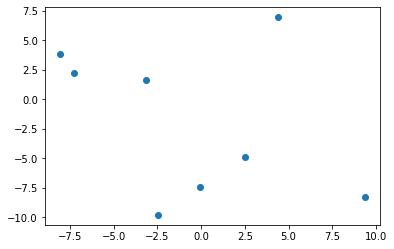


Covariance is positive definite.
(5000, 2)


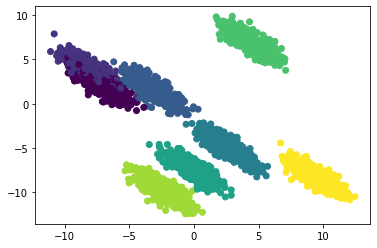

In [8]:
sample_blobs = sample_random_balls(8, var_x = 1, var_y = 1, var_xy = -0.8)
print(sample_blobs.covariance)
plt.figure()
plt.scatter(sample_blobs.mu[:, 0], sample_blobs.mu[:, 1])
plt.show()

x, l = sample_blobs.sample(5000)

print(x.shape)

plt.figure()
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.show()

## k-means run - My implementation

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 225227.8723670412
Outer iteration 0: inertia: 139988.4209397327
Outer iteration 0: inertia: 139212.70185176015
Outer iteration 0: inertia: 139212.70185176015

 Beginning outer iteration 1...
Outer iteration 1: inertia: 227409.7169477177
Outer iteration 1: inertia: 188147.36238542807
Outer iteration 1: inertia: 163319.13703208478
Outer iteration 1: inertia: 139305.9028124251
Outer iteration 1: inertia: 139212.70185176015
Outer iteration 1: inertia: 139212.70185176015

 Beginning outer iteration 2...
Outer iteration 2: inertia: 179167.46379090994
Outer iteration 2: inertia: 139546.4909730567
Outer iteration 2: inertia: 139212.70185176015
Outer iteration 2: inertia: 139212.70185176015

 Beginning outer iteration 3...
Outer iteration 3: inertia: 239469.33849469374
Outer iteration 3: inertia: 231837.22275312972
Outer iteration 3: inertia: 213869.49294177658
Outer iteration 3: inertia: 154341.9635291976
Outer i

Outer iteration 34: inertia: 221015.94652494794
Outer iteration 34: inertia: 206234.04967685376
Outer iteration 34: inertia: 173595.23091861667
Outer iteration 34: inertia: 140910.24698999454
Outer iteration 34: inertia: 139212.70185176015
Outer iteration 34: inertia: 139212.70185176015

 Beginning outer iteration 35...
Outer iteration 35: inertia: 246927.01550459728
Outer iteration 35: inertia: 233727.97003395017
Outer iteration 35: inertia: 229399.53577397225
Outer iteration 35: inertia: 227185.732990099
Outer iteration 35: inertia: 224392.55240635836
Outer iteration 35: inertia: 218106.31268985054
Outer iteration 35: inertia: 195119.36939133503
Outer iteration 35: inertia: 160098.0375048716
Outer iteration 35: inertia: 139268.71443517314
Outer iteration 35: inertia: 139212.70185176015
Outer iteration 35: inertia: 139212.70185176015

 Beginning outer iteration 36...
Outer iteration 36: inertia: 242296.86346509453
Outer iteration 36: inertia: 235451.4640386011
Outer iteration 36: iner

Outer iteration 21: inertia: 118964.64821455056
Outer iteration 21: inertia: 117851.99415485332
Outer iteration 21: inertia: 113974.00809057952
Outer iteration 21: inertia: 106314.54642585694
Outer iteration 21: inertia: 103500.42410822428
Outer iteration 21: inertia: 103164.73867885802
Outer iteration 21: inertia: 102569.01696082263
Outer iteration 21: inertia: 101089.97410641346
Outer iteration 21: inertia: 98667.9388606846
Outer iteration 21: inertia: 97422.1518539938
Outer iteration 21: inertia: 97303.07723794445
Outer iteration 21: inertia: 97296.07111358683
Outer iteration 21: inertia: 97296.07111358683

 Beginning outer iteration 22...
Outer iteration 22: inertia: 196770.10356584948
Outer iteration 22: inertia: 101474.74418168256
Outer iteration 22: inertia: 78177.77193235689
Outer iteration 22: inertia: 78085.77444322023
Outer iteration 22: inertia: 78085.77444322023

 Beginning outer iteration 23...
Outer iteration 23: inertia: 113343.01256129108
Outer iteration 23: inertia: 1

Outer iteration 44: inertia: 78085.77444322023
Outer iteration 44: inertia: 78085.77444322023

 Beginning outer iteration 45...
Outer iteration 45: inertia: 181695.76002254666
Outer iteration 45: inertia: 176890.13682141918
Outer iteration 45: inertia: 163722.73098504965
Outer iteration 45: inertia: 110206.35412855414
Outer iteration 45: inertia: 78170.03744071707
Outer iteration 45: inertia: 78085.77444322023
Outer iteration 45: inertia: 78085.77444322023

 Beginning outer iteration 46...
Outer iteration 46: inertia: 261381.69864144662
Outer iteration 46: inertia: 260881.85301005517
Outer iteration 46: inertia: 260822.96979682744
Outer iteration 46: inertia: 260802.3829994834
Outer iteration 46: inertia: 260790.2879491288
Outer iteration 46: inertia: 260786.24727589186
Outer iteration 46: inertia: 260784.17435615542
Outer iteration 46: inertia: 260783.92452956733
Outer iteration 46: inertia: 260783.91130911722
Outer iteration 46: inertia: 260783.9015190806
Outer iteration 46: inertia:

Outer iteration 13: inertia: 68340.37614207159
Outer iteration 13: inertia: 68320.27332101532
Outer iteration 13: inertia: 68318.83692367183
Outer iteration 13: inertia: 68318.77621352326
Outer iteration 13: inertia: 68318.77621352326

 Beginning outer iteration 14...
Outer iteration 14: inertia: 104566.32526652544
Outer iteration 14: inertia: 70675.66687744281
Outer iteration 14: inertia: 58051.39953904523
Outer iteration 14: inertia: 50991.73295442002
Outer iteration 14: inertia: 41771.85171714516
Outer iteration 14: inertia: 39575.96585254679
Outer iteration 14: inertia: 37104.75080760568
Outer iteration 14: inertia: 36223.57685990859
Outer iteration 14: inertia: 36153.684526610516
Outer iteration 14: inertia: 36148.745886268785
Outer iteration 14: inertia: 36148.745886268785

 Beginning outer iteration 15...
Outer iteration 15: inertia: 99663.58418099623
Outer iteration 15: inertia: 90978.51702374853
Outer iteration 15: inertia: 85759.44597296216
Outer iteration 15: inertia: 85533.

Outer iteration 41: inertia: 44416.194660083915
Outer iteration 41: inertia: 42478.05505767311
Outer iteration 41: inertia: 42140.08920115986
Outer iteration 41: inertia: 41627.746087084815
Outer iteration 41: inertia: 40274.39848009667
Outer iteration 41: inertia: 37913.94167495261
Outer iteration 41: inertia: 36352.576049370124
Outer iteration 41: inertia: 36158.25573908373
Outer iteration 41: inertia: 36149.270273270275
Outer iteration 41: inertia: 36148.74588626878
Outer iteration 41: inertia: 36148.74588626878

 Beginning outer iteration 42...
Outer iteration 42: inertia: 75206.62400518521
Outer iteration 42: inertia: 69370.79865537901
Outer iteration 42: inertia: 68443.74134926176
Outer iteration 42: inertia: 68329.59182847159
Outer iteration 42: inertia: 68320.05894971122
Outer iteration 42: inertia: 68318.97427115319
Outer iteration 42: inertia: 68318.82780779072
Outer iteration 42: inertia: 68318.77621352326
Outer iteration 42: inertia: 68318.77621352326

 Beginning outer iter

Outer iteration 11: inertia: 35427.82148494482
Outer iteration 11: inertia: 35427.76758767827
Outer iteration 11: inertia: 35427.76758767827

 Beginning outer iteration 12...
Outer iteration 12: inertia: 55389.1592222306
Outer iteration 12: inertia: 31305.813712255378
Outer iteration 12: inertia: 26826.23176460451
Outer iteration 12: inertia: 26473.156418082413
Outer iteration 12: inertia: 26443.323274188293
Outer iteration 12: inertia: 26439.18055237947
Outer iteration 12: inertia: 26438.483999659937
Outer iteration 12: inertia: 26438.41299577938
Outer iteration 12: inertia: 26438.41299577938

 Beginning outer iteration 13...
Outer iteration 13: inertia: 81348.15262919635
Outer iteration 13: inertia: 44677.26982117445
Outer iteration 13: inertia: 34217.89405535816
Outer iteration 13: inertia: 32747.68386427996
Outer iteration 13: inertia: 31773.020527891946
Outer iteration 13: inertia: 30221.166653558445
Outer iteration 13: inertia: 27816.72660448382
Outer iteration 13: inertia: 26565

Outer iteration 32: inertia: 24269.892846666073
Outer iteration 32: inertia: 24269.862662255175
Outer iteration 32: inertia: 24269.862662255175

 Beginning outer iteration 33...
Outer iteration 33: inertia: 35535.92071685662
Outer iteration 33: inertia: 35455.78814173382
Outer iteration 33: inertia: 35441.480397108426
Outer iteration 33: inertia: 35434.566344285726
Outer iteration 33: inertia: 35430.194968339274
Outer iteration 33: inertia: 35428.92930828739
Outer iteration 33: inertia: 35428.24783614288
Outer iteration 33: inertia: 35427.96661547087
Outer iteration 33: inertia: 35427.74671173021
Outer iteration 33: inertia: 35427.74671173021

 Beginning outer iteration 34...
Outer iteration 34: inertia: 68638.90515417811
Outer iteration 34: inertia: 34679.37051003577
Outer iteration 34: inertia: 24334.488126603283
Outer iteration 34: inertia: 24297.63601896029
Outer iteration 34: inertia: 24287.20690679062
Outer iteration 34: inertia: 24282.934001749127
Outer iteration 34: inertia: 24

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 23107.00916665973
Outer iteration 0: inertia: 22380.08366994456
Outer iteration 0: inertia: 22101.324076118726
Outer iteration 0: inertia: 21625.76452630928
Outer iteration 0: inertia: 20183.4381186479
Outer iteration 0: inertia: 16731.490397328365
Outer iteration 0: inertia: 14461.78001977316
Outer iteration 0: inertia: 14130.804263637125
Outer iteration 0: inertia: 14105.487570593637
Outer iteration 0: inertia: 14102.95847061001
Outer iteration 0: inertia: 14102.66143202981
Outer iteration 0: inertia: 14102.66143202981

 Beginning outer iteration 1...
Outer iteration 1: inertia: 50336.30614533829
Outer iteration 1: inertia: 36649.2601654573
Outer iteration 1: inertia: 23538.885989626542
Outer iteration 1: inertia: 16319.253212772466
Outer iteration 1: inertia: 14947.613016098503
Outer iteration 1: inertia: 14373.430624860226
Outer iteration 1: inertia: 14160.795667146696
Outer iteration 1: inertia: 1411

Outer iteration 16: inertia: 25758.40613181677
Outer iteration 16: inertia: 25724.620723288015
Outer iteration 16: inertia: 25719.259939040378
Outer iteration 16: inertia: 25718.31274674109
Outer iteration 16: inertia: 25717.75569822341
Outer iteration 16: inertia: 25717.502240797305
Outer iteration 16: inertia: 25717.44834353075
Outer iteration 16: inertia: 25717.44834353075

 Beginning outer iteration 17...
Outer iteration 17: inertia: 80013.9570717251
Outer iteration 17: inertia: 23223.32668601299
Outer iteration 17: inertia: 22970.01790495322
Outer iteration 17: inertia: 22927.12296692621
Outer iteration 17: inertia: 22915.66847076746
Outer iteration 17: inertia: 22909.35733028826
Outer iteration 17: inertia: 22904.154678986375
Outer iteration 17: inertia: 22900.886081653505
Outer iteration 17: inertia: 22898.820568102394
Outer iteration 17: inertia: 22898.301845975006
Outer iteration 17: inertia: 22898.142472422605
Outer iteration 17: inertia: 22897.943734078533
Outer iteration 17

Outer iteration 32: inertia: 30340.89805613052
Outer iteration 32: inertia: 28399.26268930715
Outer iteration 32: inertia: 26241.379767358176
Outer iteration 32: inertia: 25753.642262197587
Outer iteration 32: inertia: 25719.899767600335
Outer iteration 32: inertia: 25717.448343530745
Outer iteration 32: inertia: 25717.448343530745

 Beginning outer iteration 33...
Outer iteration 33: inertia: 21357.95380235824
Outer iteration 33: inertia: 14523.676489652265
Outer iteration 33: inertia: 14209.272798116755
Outer iteration 33: inertia: 14124.945067223447
Outer iteration 33: inertia: 14104.57564975321
Outer iteration 33: inertia: 14102.661432029809
Outer iteration 33: inertia: 14102.661432029809

 Beginning outer iteration 34...
Outer iteration 34: inertia: 37451.49707922115
Outer iteration 34: inertia: 15415.231819039373
Outer iteration 34: inertia: 14429.468365633462
Outer iteration 34: inertia: 14227.22543963464
Outer iteration 34: inertia: 14115.320198459247
Outer iteration 34: inerti

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 40108.5026990372
Outer iteration 0: inertia: 23757.72878806554
Outer iteration 0: inertia: 15000.452290083747
Outer iteration 0: inertia: 13666.863459966411
Outer iteration 0: inertia: 13353.744910325588
Outer iteration 0: inertia: 12934.09720489598
Outer iteration 0: inertia: 11996.338235572763
Outer iteration 0: inertia: 10812.899171037232
Outer iteration 0: inertia: 10691.439793615784
Outer iteration 0: inertia: 10691.439793615784

 Beginning outer iteration 1...
Outer iteration 1: inertia: 22365.567822015608
Outer iteration 1: inertia: 21768.266276832663
Outer iteration 1: inertia: 21643.323233379066
Outer iteration 1: inertia: 21479.200716359097
Outer iteration 1: inertia: 21159.31712891186
Outer iteration 1: inertia: 20579.671543939072
Outer iteration 1: inertia: 18278.028819571722
Outer iteration 1: inertia: 14687.498447431622
Outer iteration 1: inertia: 13518.231447474227
Outer iteration 1: inerti

Outer iteration 13: inertia: 29632.766457950645
Outer iteration 13: inertia: 14472.206106634252
Outer iteration 13: inertia: 11145.405016244347
Outer iteration 13: inertia: 10732.913397241227
Outer iteration 13: inertia: 10696.8018100365
Outer iteration 13: inertia: 10691.539565912375
Outer iteration 13: inertia: 10691.439793615784
Outer iteration 13: inertia: 10691.439793615784

 Beginning outer iteration 14...
Outer iteration 14: inertia: 34817.45389001844
Outer iteration 14: inertia: 26596.13864377786
Outer iteration 14: inertia: 17267.205373723184
Outer iteration 14: inertia: 14101.420560863517
Outer iteration 14: inertia: 13977.434308364403
Outer iteration 14: inertia: 13965.247511099944
Outer iteration 14: inertia: 13961.157933183993
Outer iteration 14: inertia: 13958.53062842226
Outer iteration 14: inertia: 13955.907665328183
Outer iteration 14: inertia: 13954.787025300968
Outer iteration 14: inertia: 13953.803071752529
Outer iteration 14: inertia: 13952.865419955075
Outer itera

Outer iteration 26: inertia: 12939.56415216743
Outer iteration 26: inertia: 12939.496234604725
Outer iteration 26: inertia: 12939.496234604725

 Beginning outer iteration 27...
Outer iteration 27: inertia: 22034.46910919907
Outer iteration 27: inertia: 21514.652580619546
Outer iteration 27: inertia: 21380.978454939494
Outer iteration 27: inertia: 21189.09774937379
Outer iteration 27: inertia: 20725.248909693542
Outer iteration 27: inertia: 19833.582940228913
Outer iteration 27: inertia: 19517.619776068837
Outer iteration 27: inertia: 19517.619776068837

 Beginning outer iteration 28...
Outer iteration 28: inertia: 89297.83809538349
Outer iteration 28: inertia: 42675.294978028236
Outer iteration 28: inertia: 17100.258795952606
Outer iteration 28: inertia: 14306.06668100024
Outer iteration 28: inertia: 13800.867536724903
Outer iteration 28: inertia: 13593.330800142585
Outer iteration 28: inertia: 13447.703223327104
Outer iteration 28: inertia: 13235.822331258349
Outer iteration 28: inert

Outer iteration 39: inertia: 19745.24563116912
Outer iteration 39: inertia: 19740.015331311086
Outer iteration 39: inertia: 19727.21288438081
Outer iteration 39: inertia: 19701.367201720772
Outer iteration 39: inertia: 19645.524365268055
Outer iteration 39: inertia: 19583.343101076247
Outer iteration 39: inertia: 19543.335675509392
Outer iteration 39: inertia: 19527.56895765686
Outer iteration 39: inertia: 19522.106766276756
Outer iteration 39: inertia: 19516.87621616238
Outer iteration 39: inertia: 19514.294937067534
Outer iteration 39: inertia: 19512.93632401487
Outer iteration 39: inertia: 19511.853816254235
Outer iteration 39: inertia: 19509.99360226048
Outer iteration 39: inertia: 19507.213073978583
Outer iteration 39: inertia: 19506.3963226036
Outer iteration 39: inertia: 19505.783595549357
Outer iteration 39: inertia: 19505.73771845566
Outer iteration 39: inertia: 19505.72116881452
Outer iteration 39: inertia: 19505.66320803077
Outer iteration 39: inertia: 19505.593250080983
Out

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 20070.57314264325
Outer iteration 0: inertia: 19121.36876497851
Outer iteration 0: inertia: 18768.89345913939
Outer iteration 0: inertia: 18758.36965464278
Outer iteration 0: inertia: 18756.730880423784
Outer iteration 0: inertia: 18756.37255069491
Outer iteration 0: inertia: 18756.282358561042
Outer iteration 0: inertia: 18756.282358561042

 Beginning outer iteration 1...
Outer iteration 1: inertia: 21200.738511777083
Outer iteration 1: inertia: 12606.21611343321
Outer iteration 1: inertia: 12315.1031238679
Outer iteration 1: inertia: 11906.811499010204
Outer iteration 1: inertia: 10886.494736190309
Outer iteration 1: inertia: 10076.112985312222
Outer iteration 1: inertia: 9976.984270024552
Outer iteration 1: inertia: 9957.172160526663
Outer iteration 1: inertia: 9953.28836352179
Outer iteration 1: inertia: 9950.085239650547
Outer iteration 1: inertia: 9949.187674898032
Outer iteration 1: inertia: 9948.9

Outer iteration 10: inertia: 9949.635829979568
Outer iteration 10: inertia: 9949.014780071022
Outer iteration 10: inertia: 9948.852274629899
Outer iteration 10: inertia: 9948.818963756738
Outer iteration 10: inertia: 9948.818963756738

 Beginning outer iteration 11...
Outer iteration 11: inertia: 65847.6318114308
Outer iteration 11: inertia: 35909.06007727151
Outer iteration 11: inertia: 13725.430411812064
Outer iteration 11: inertia: 13282.538583742513
Outer iteration 11: inertia: 13170.849535390116
Outer iteration 11: inertia: 13138.013114731673
Outer iteration 11: inertia: 13131.23375798811
Outer iteration 11: inertia: 13127.9881926437
Outer iteration 11: inertia: 13122.680523149396
Outer iteration 11: inertia: 13117.979280875004
Outer iteration 11: inertia: 13114.370505452287
Outer iteration 11: inertia: 13107.921710953151
Outer iteration 11: inertia: 13104.088078328938
Outer iteration 11: inertia: 13100.76175904118
Outer iteration 11: inertia: 13098.094540769189
Outer iteration 11

C:\Users\ryanb.LAPTOP-4EHB9TVB\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ryanb.LAPTOP-4EHB9TVB\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Outer iteration 21: inertia: 12203.793161826747
Outer iteration 21: inertia: 12201.954745741805
Outer iteration 21: inertia: 12194.788332650158
Outer iteration 21: inertia: 12181.927352364593
Outer iteration 21: inertia: 12152.482690243283
Outer iteration 21: inertia: 12057.905754723928
Outer iteration 21: inertia: 11864.31039940907
Outer iteration 21: inertia: 11700.807704963845
Outer iteration 21: inertia: 11652.240266180466
Outer iteration 21: inertia: 11648.715929579717
Outer iteration 21: inertia: 11648.715929579717

 Beginning outer iteration 22...
Outer iteration 22: inertia: 16248.681895517166
Outer iteration 22: inertia: 14333.76562321417
Outer iteration 22: inertia: 12934.11548092305
Outer iteration 22: inertia: 10260.833646199453
Outer iteration 22: inertia: 9963.917774443855
Outer iteration 22: inertia: 9949.836589162087
Outer iteration 22: inertia: 9949.30694986974
Outer iteration 22: inertia: 9949.221858096946
Outer iteration 22: inertia: 9948.985064417371
Outer iteration

Outer iteration 32: inertia: 24786.09190593451
Outer iteration 32: inertia: 24585.625217916506
Outer iteration 32: inertia: 24489.39655417724
Outer iteration 32: inertia: 24373.261353794758
Outer iteration 32: inertia: 24011.487992889342
Outer iteration 32: inertia: 22117.667834870077
Outer iteration 32: inertia: 14442.448916910567
Outer iteration 32: inertia: 13188.681596306313
Outer iteration 32: inertia: 13183.1664866061
Outer iteration 32: inertia: 13182.440582862495
Outer iteration 32: inertia: 13182.239981831648
Outer iteration 32: inertia: 13182.126638619025
Outer iteration 32: inertia: 13182.009118931637
Outer iteration 32: inertia: 13181.887494283943
Outer iteration 32: inertia: 13181.856001327862
Outer iteration 32: inertia: 13181.781281406638
Outer iteration 32: inertia: 13181.750355226246
Outer iteration 32: inertia: 13181.742985906447
Outer iteration 32: inertia: 13181.742985906447

 Beginning outer iteration 33...
Outer iteration 33: inertia: 32713.066720582126
Outer iter

Outer iteration 40: inertia: 12466.155333305205
Outer iteration 40: inertia: 12466.032992903558
Outer iteration 40: inertia: 12466.019127938782
Outer iteration 40: inertia: 12465.997019316223
Outer iteration 40: inertia: 12465.981164353349
Outer iteration 40: inertia: 12465.981164353349

 Beginning outer iteration 41...
Outer iteration 41: inertia: 17664.59670070255
Outer iteration 41: inertia: 12928.553661286542
Outer iteration 41: inertia: 10901.398236274916
Outer iteration 41: inertia: 10245.070737257372
Outer iteration 41: inertia: 10015.233188902394
Outer iteration 41: inertia: 9960.690801236147
Outer iteration 41: inertia: 9948.704881963877
Outer iteration 41: inertia: 9948.239900130548
Outer iteration 41: inertia: 9948.239900130548

 Beginning outer iteration 42...
Outer iteration 42: inertia: 13180.724562208996
Outer iteration 42: inertia: 12611.884469494938
Outer iteration 42: inertia: 12434.65789663178
Outer iteration 42: inertia: 12332.754457645195
Outer iteration 42: inerti

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 49323.48496873281
Outer iteration 0: inertia: 22944.989150367423
Outer iteration 0: inertia: 13655.103320704522
Outer iteration 0: inertia: 11627.68020949522
Outer iteration 0: inertia: 11468.680215436507
Outer iteration 0: inertia: 11358.746546772833
Outer iteration 0: inertia: 11244.38123653736
Outer iteration 0: inertia: 11022.323588016285
Outer iteration 0: inertia: 10593.194250879566
Outer iteration 0: inertia: 9978.541170459543
Outer iteration 0: inertia: 9089.134752072701
Outer iteration 0: inertia: 8483.78833512046
Outer iteration 0: inertia: 8483.009358004982
Outer iteration 0: inertia: 8482.941469976524
Outer iteration 0: inertia: 8482.91449569248
Outer iteration 0: inertia: 8482.91449569248

 Beginning outer iteration 1...
Outer iteration 1: inertia: 9332.726627128273
Outer iteration 1: inertia: 8298.7927410294
Outer iteration 1: inertia: 8238.973825735367
Outer iteration 1: inertia: 8226.82310

Outer iteration 13: inertia: 9205.726322672523
Outer iteration 13: inertia: 9205.646079707294
Outer iteration 13: inertia: 9205.619070271503
Outer iteration 13: inertia: 9205.619070271503

 Beginning outer iteration 14...
Outer iteration 14: inertia: 22138.304821956226
Outer iteration 14: inertia: 13870.859460672289
Outer iteration 14: inertia: 11556.453076892449
Outer iteration 14: inertia: 11345.433053823821
Outer iteration 14: inertia: 11223.201469104304
Outer iteration 14: inertia: 11157.395605064627
Outer iteration 14: inertia: 11119.817515273404
Outer iteration 14: inertia: 11093.21179942077
Outer iteration 14: inertia: 11084.176291235948
Outer iteration 14: inertia: 11082.083843132672
Outer iteration 14: inertia: 11080.238608272082
Outer iteration 14: inertia: 11078.56632291871
Outer iteration 14: inertia: 11077.822783422933
Outer iteration 14: inertia: 11076.806054534733
Outer iteration 14: inertia: 11076.024857001974
Outer iteration 14: inertia: 11075.844365349792
Outer iterat

Outer iteration 26: inertia: 11490.434119527548
Outer iteration 26: inertia: 11390.895575074777
Outer iteration 26: inertia: 11288.973020511083
Outer iteration 26: inertia: 11247.361713895963
Outer iteration 26: inertia: 11231.772878706779
Outer iteration 26: inertia: 11223.156412813114
Outer iteration 26: inertia: 11218.82796093194
Outer iteration 26: inertia: 11216.943167755046
Outer iteration 26: inertia: 11215.613211317253
Outer iteration 26: inertia: 11214.562219237461
Outer iteration 26: inertia: 11213.677729883428
Outer iteration 26: inertia: 11212.532598418466
Outer iteration 26: inertia: 11211.640142655
Outer iteration 26: inertia: 11211.416973057163
Outer iteration 26: inertia: 11211.27697306839
Outer iteration 26: inertia: 11211.087961931957
Outer iteration 26: inertia: 11210.969053390245
Outer iteration 26: inertia: 11210.91369381583
Outer iteration 26: inertia: 11210.847146734235
Outer iteration 26: inertia: 11210.800277028991
Outer iteration 26: inertia: 11210.80027702899

Outer iteration 36: inertia: 23611.961734343466
Outer iteration 36: inertia: 23386.97733743827
Outer iteration 36: inertia: 23330.044419028247
Outer iteration 36: inertia: 23316.097463239905
Outer iteration 36: inertia: 23310.23197552039
Outer iteration 36: inertia: 23309.17945227443
Outer iteration 36: inertia: 23308.835290349307
Outer iteration 36: inertia: 23308.66212012726
Outer iteration 36: inertia: 23308.567227408024
Outer iteration 36: inertia: 23308.502396292362
Outer iteration 36: inertia: 23308.42796346441
Outer iteration 36: inertia: 23308.280483810107
Outer iteration 36: inertia: 23308.17113749691
Outer iteration 36: inertia: 23308.002215947803
Outer iteration 36: inertia: 23307.80421255183
Outer iteration 36: inertia: 23307.381744900995
Outer iteration 36: inertia: 23306.58177681801
Outer iteration 36: inertia: 23306.159386528583
Outer iteration 36: inertia: 23305.813348725198
Outer iteration 36: inertia: 23305.678119831075
Outer iteration 36: inertia: 23305.585742707706


Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 20846.560713401257
Outer iteration 0: inertia: 10506.848409661057
Outer iteration 0: inertia: 8158.673827163981
Outer iteration 0: inertia: 8030.5154258364255
Outer iteration 0: inertia: 8022.094697959499
Outer iteration 0: inertia: 8020.267373876313
Outer iteration 0: inertia: 8019.242351808821
Outer iteration 0: inertia: 8018.85691311608
Outer iteration 0: inertia: 8018.695099194114
Outer iteration 0: inertia: 8017.5222185931625
Outer iteration 0: inertia: 8016.016053264355
Outer iteration 0: inertia: 8011.164225951837
Outer iteration 0: inertia: 8002.918275275814
Outer iteration 0: inertia: 7982.224825387172
Outer iteration 0: inertia: 7911.298552386463
Outer iteration 0: inertia: 7763.89407174623
Outer iteration 0: inertia: 7601.307332001688
Outer iteration 0: inertia: 7530.276384750848
Outer iteration 0: inertia: 7509.190873798956
Outer iteration 0: inertia: 7501.7920230888285
Outer iteration 0: iner

Outer iteration 13: inertia: 10804.372963460653
Outer iteration 13: inertia: 10749.826055579424
Outer iteration 13: inertia: 10745.78798218201
Outer iteration 13: inertia: 10745.671470762498
Outer iteration 13: inertia: 10745.671470762498

 Beginning outer iteration 14...
Outer iteration 14: inertia: 9748.479897914816
Outer iteration 14: inertia: 9135.360329228175
Outer iteration 14: inertia: 9034.178679894589
Outer iteration 14: inertia: 8997.528023498851
Outer iteration 14: inertia: 8984.023332866846
Outer iteration 14: inertia: 8973.945459293616
Outer iteration 14: inertia: 8968.9167457553
Outer iteration 14: inertia: 8965.300224764886
Outer iteration 14: inertia: 8961.646535928014
Outer iteration 14: inertia: 8959.16431508077
Outer iteration 14: inertia: 8957.11914369815
Outer iteration 14: inertia: 8955.791353320612
Outer iteration 14: inertia: 8953.774124826223
Outer iteration 14: inertia: 8953.057071727015
Outer iteration 14: inertia: 8952.324455994905
Outer iteration 14: inerti

Outer iteration 25: inertia: 7743.086142906518
Outer iteration 25: inertia: 7742.807123359886
Outer iteration 25: inertia: 7742.510858597651
Outer iteration 25: inertia: 7742.388518196007
Outer iteration 25: inertia: 7742.374653231231
Outer iteration 25: inertia: 7742.352544608671
Outer iteration 25: inertia: 7742.336689645796
Outer iteration 25: inertia: 7742.336689645796

 Beginning outer iteration 26...
Outer iteration 26: inertia: 11446.383831840956
Outer iteration 26: inertia: 10452.342181592421
Outer iteration 26: inertia: 9929.923187395209
Outer iteration 26: inertia: 8921.497595311508
Outer iteration 26: inertia: 8073.250629439453
Outer iteration 26: inertia: 8047.082892198842
Outer iteration 26: inertia: 8043.174451495636
Outer iteration 26: inertia: 8040.474226658605
Outer iteration 26: inertia: 8038.886957803027
Outer iteration 26: inertia: 8038.230096703499
Outer iteration 26: inertia: 8038.003384070105
Outer iteration 26: inertia: 8037.698652010349
Outer iteration 26: iner

Outer iteration 34: inertia: 11057.393657058754
Outer iteration 34: inertia: 11057.20464592232
Outer iteration 34: inertia: 11057.085737380607
Outer iteration 34: inertia: 11057.030377806193
Outer iteration 34: inertia: 11056.963830724597
Outer iteration 34: inertia: 11056.916961019353
Outer iteration 34: inertia: 11056.916961019353

 Beginning outer iteration 35...
Outer iteration 35: inertia: 26603.05689185798
Outer iteration 35: inertia: 17625.779962465214
Outer iteration 35: inertia: 11677.648869530298
Outer iteration 35: inertia: 10961.670864479926
Outer iteration 35: inertia: 10451.534409707869
Outer iteration 35: inertia: 9364.631854898455
Outer iteration 35: inertia: 7835.760807663804
Outer iteration 35: inertia: 7550.149232224628
Outer iteration 35: inertia: 7527.33460731322
Outer iteration 35: inertia: 7520.557844810472
Outer iteration 35: inertia: 7514.763812954395
Outer iteration 35: inertia: 7512.494264912865
Outer iteration 35: inertia: 7510.073940887528
Outer iteration 3

Outer iteration 46: inertia: 8510.09848582074
Outer iteration 46: inertia: 8504.563012591727
Outer iteration 46: inertia: 8501.849135507928
Outer iteration 46: inertia: 8501.655734041942
Outer iteration 46: inertia: 8501.604615135551
Outer iteration 46: inertia: 8501.595611982451
Outer iteration 46: inertia: 8501.595611982451

 Beginning outer iteration 47...
Outer iteration 47: inertia: 104005.72244134759
Outer iteration 47: inertia: 94518.68252639286
Outer iteration 47: inertia: 81791.70467279384
Outer iteration 47: inertia: 80287.08591603958
Outer iteration 47: inertia: 80125.74992702357
Outer iteration 47: inertia: 79911.29279845345
Outer iteration 47: inertia: 79789.5758405082
Outer iteration 47: inertia: 79745.94562549729
Outer iteration 47: inertia: 79727.808914787
Outer iteration 47: inertia: 79719.10040397207
Outer iteration 47: inertia: 79713.58995786897
Outer iteration 47: inertia: 79709.98774615499
Outer iteration 47: inertia: 79706.05178576578
Outer iteration 47: inertia: 


 Beginning outer iteration 5...
Outer iteration 5: inertia: 16814.593805820397
Outer iteration 5: inertia: 11106.640922423188
Outer iteration 5: inertia: 10850.053892316406
Outer iteration 5: inertia: 10750.693000889894
Outer iteration 5: inertia: 10600.97360253298
Outer iteration 5: inertia: 10426.689677674936
Outer iteration 5: inertia: 10308.592999014449
Outer iteration 5: inertia: 10261.114201489783
Outer iteration 5: inertia: 10240.9663495047
Outer iteration 5: inertia: 10226.398711992631
Outer iteration 5: inertia: 10216.879388898607
Outer iteration 5: inertia: 10207.135471211943
Outer iteration 5: inertia: 10195.345648504153
Outer iteration 5: inertia: 10182.082981867168
Outer iteration 5: inertia: 10158.258662691333
Outer iteration 5: inertia: 10113.632098397966
Outer iteration 5: inertia: 10041.078404658587
Outer iteration 5: inertia: 9939.361337325441
Outer iteration 5: inertia: 9839.997917149612
Outer iteration 5: inertia: 9773.459288023843
Outer iteration 5: inertia: 9734.

Outer iteration 13: inertia: 7529.370796979206
Outer iteration 13: inertia: 7529.24845657756
Outer iteration 13: inertia: 7529.234591612784
Outer iteration 13: inertia: 7529.212482990225
Outer iteration 13: inertia: 7529.196628027349
Outer iteration 13: inertia: 7529.196628027349

 Beginning outer iteration 14...
Outer iteration 14: inertia: 27308.861991894755
Outer iteration 14: inertia: 9194.987504709814
Outer iteration 14: inertia: 8836.744282546708
Outer iteration 14: inertia: 8762.0522985293
Outer iteration 14: inertia: 8740.856378972498
Outer iteration 14: inertia: 8736.658872530012
Outer iteration 14: inertia: 8735.478220280229
Outer iteration 14: inertia: 8734.157354994404
Outer iteration 14: inertia: 8733.15554120393
Outer iteration 14: inertia: 8731.424337819875
Outer iteration 14: inertia: 8730.123290656109
Outer iteration 14: inertia: 8729.166997366669
Outer iteration 14: inertia: 8727.184490478692
Outer iteration 14: inertia: 8723.842029200241
Outer iteration 14: inertia: 

Outer iteration 22: inertia: 7067.815873675093
Outer iteration 22: inertia: 6847.133743360175
Outer iteration 22: inertia: 6752.862572947642
Outer iteration 22: inertia: 6728.196099580522
Outer iteration 22: inertia: 6716.42340509893
Outer iteration 22: inertia: 6712.4133162230755
Outer iteration 22: inertia: 6708.869821335511
Outer iteration 22: inertia: 6706.007741960291
Outer iteration 22: inertia: 6704.907648414604
Outer iteration 22: inertia: 6704.107224905346
Outer iteration 22: inertia: 6704.034388738715
Outer iteration 22: inertia: 6704.0084675194275
Outer iteration 22: inertia: 6704.0084675194275

 Beginning outer iteration 23...
Outer iteration 23: inertia: 11745.92280904901
Outer iteration 23: inertia: 10409.774990114134
Outer iteration 23: inertia: 8583.482792671719
Outer iteration 23: inertia: 8392.01818945074
Outer iteration 23: inertia: 8340.837867569762
Outer iteration 23: inertia: 8315.293621206474
Outer iteration 23: inertia: 8302.129319821368
Outer iteration 23: iner

Outer iteration 32: inertia: 8697.514219834009
Outer iteration 32: inertia: 8695.00918192149
Outer iteration 32: inertia: 8694.182858691702
Outer iteration 32: inertia: 8692.813301935552
Outer iteration 32: inertia: 8689.541116630882
Outer iteration 32: inertia: 8683.461497212049
Outer iteration 32: inertia: 8674.89489159162
Outer iteration 32: inertia: 8669.022341542752
Outer iteration 32: inertia: 8660.883121735653
Outer iteration 32: inertia: 8639.600638087746
Outer iteration 32: inertia: 8602.019576625325
Outer iteration 32: inertia: 8522.847646359221
Outer iteration 32: inertia: 8424.066888272411
Outer iteration 32: inertia: 8349.66600003577
Outer iteration 32: inertia: 8294.229442717668
Outer iteration 32: inertia: 8258.347344084897
Outer iteration 32: inertia: 8244.834673901727
Outer iteration 32: inertia: 8240.344026731758
Outer iteration 32: inertia: 8239.653676593563
Outer iteration 32: inertia: 8238.950150613204
Outer iteration 32: inertia: 8238.298338476246
Outer iteration 

Outer iteration 40: inertia: 10337.519581586792
Outer iteration 40: inertia: 10272.547538648227
Outer iteration 40: inertia: 10257.549116113358
Outer iteration 40: inertia: 10249.276973507358
Outer iteration 40: inertia: 10242.694874355297
Outer iteration 40: inertia: 10238.206365478638
Outer iteration 40: inertia: 10235.505074463725
Outer iteration 40: inertia: 10234.733254985493
Outer iteration 40: inertia: 10234.487760307067
Outer iteration 40: inertia: 10234.199490095076
Outer iteration 40: inertia: 10234.075572999758
Outer iteration 40: inertia: 10233.92089720658
Outer iteration 40: inertia: 10233.746408116484
Outer iteration 40: inertia: 10233.637061803289
Outer iteration 40: inertia: 10233.46814025418
Outer iteration 40: inertia: 10233.27013685821
Outer iteration 40: inertia: 10232.916294849478
Outer iteration 40: inertia: 10232.243274445935
Outer iteration 40: inertia: 10231.964254899302
Outer iteration 40: inertia: 10231.66799013707
Outer iteration 40: inertia: 10231.545649735

Outer iteration 48: inertia: 7057.2401729226185
Outer iteration 48: inertia: 7057.118644567883
Outer iteration 48: inertia: 7057.020634380027
Outer iteration 48: inertia: 7056.965274805614
Outer iteration 48: inertia: 7056.898727724021
Outer iteration 48: inertia: 7056.851858018776
Outer iteration 48: inertia: 7056.851858018776

 Beginning outer iteration 49...
Outer iteration 49: inertia: 11680.95655193052

 Finished Training! Automatically selecting optimal centers...
Calculating the Silhouette score...
Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 11555.855821104618
Outer iteration 0: inertia: 8270.636074363712
Outer iteration 0: inertia: 6913.45366111556
Outer iteration 0: inertia: 6842.3354430023965
Outer iteration 0: inertia: 6829.32655472674
Outer iteration 0: inertia: 6826.240137735965
Outer iteration 0: inertia: 6825.067289486452
Outer iteration 0: inertia: 6824.428544944949
Outer iteration 0: inertia: 6823.749692377574
Outer iteration 0: in

Outer iteration 5: inertia: 6427.807457852829
Outer iteration 5: inertia: 6370.549231049106
Outer iteration 5: inertia: 6334.207891183268
Outer iteration 5: inertia: 6320.639214544541
Outer iteration 5: inertia: 6315.895214709341
Outer iteration 5: inertia: 6314.876984490674
Outer iteration 5: inertia: 6314.124764057245
Outer iteration 5: inertia: 6313.617972300072
Outer iteration 5: inertia: 6313.3755549777525
Outer iteration 5: inertia: 6313.3538886654005
Outer iteration 5: inertia: 6313.339629087947
Outer iteration 5: inertia: 6313.339629087947

 Beginning outer iteration 6...
Outer iteration 6: inertia: 35778.44195052203
Outer iteration 6: inertia: 24906.245128808707
Outer iteration 6: inertia: 9116.802360937158
Outer iteration 6: inertia: 8367.371858184948
Outer iteration 6: inertia: 8132.222368532868
Outer iteration 6: inertia: 8059.447497888723
Outer iteration 6: inertia: 8039.069796960673
Outer iteration 6: inertia: 8034.718801980487
Outer iteration 6: inertia: 8034.24985185688

Outer iteration 13: inertia: 6944.818342647615
Outer iteration 13: inertia: 6910.338331261208
Outer iteration 13: inertia: 6896.480491388403
Outer iteration 13: inertia: 6888.764119499988
Outer iteration 13: inertia: 6885.813911935398
Outer iteration 13: inertia: 6883.350704887967
Outer iteration 13: inertia: 6881.937836906716
Outer iteration 13: inertia: 6881.526944069561
Outer iteration 13: inertia: 6881.141282338508
Outer iteration 13: inertia: 6880.981809935179
Outer iteration 13: inertia: 6880.796289971328
Outer iteration 13: inertia: 6880.7647970152475
Outer iteration 13: inertia: 6880.690077094025
Outer iteration 13: inertia: 6880.65915091363
Outer iteration 13: inertia: 6880.651781593833
Outer iteration 13: inertia: 6880.651781593833

 Beginning outer iteration 14...
Outer iteration 14: inertia: 10970.966689964438
Outer iteration 14: inertia: 7341.730915544747
Outer iteration 14: inertia: 6720.659510482795
Outer iteration 14: inertia: 6560.157644509616
Outer iteration 14: inert


 Beginning outer iteration 21...
Outer iteration 21: inertia: 16044.451884411033
Outer iteration 21: inertia: 7854.455334666549
Outer iteration 21: inertia: 6918.640715187839
Outer iteration 21: inertia: 6831.927104049638
Outer iteration 21: inertia: 6808.6742913364515
Outer iteration 21: inertia: 6795.639025343545
Outer iteration 21: inertia: 6783.598731463263
Outer iteration 21: inertia: 6771.490319571654
Outer iteration 21: inertia: 6763.883162952996
Outer iteration 21: inertia: 6757.249319231786
Outer iteration 21: inertia: 6750.152651569408
Outer iteration 21: inertia: 6740.876114521609
Outer iteration 21: inertia: 6734.772395710654
Outer iteration 21: inertia: 6730.335849171588
Outer iteration 21: inertia: 6727.558197704744
Outer iteration 21: inertia: 6724.268531064929
Outer iteration 21: inertia: 6721.240470138745
Outer iteration 21: inertia: 6717.456553496777
Outer iteration 21: inertia: 6711.006897837511
Outer iteration 21: inertia: 6701.2402268117385
Outer iteration 21: ine

Outer iteration 27: inertia: 7165.2218208182785
Outer iteration 27: inertia: 7009.609444705063
Outer iteration 27: inertia: 6860.609586052103
Outer iteration 27: inertia: 6724.299305284314
Outer iteration 27: inertia: 6606.973856547933
Outer iteration 27: inertia: 6550.520459446972
Outer iteration 27: inertia: 6524.890927759756
Outer iteration 27: inertia: 6509.263518425671
Outer iteration 27: inertia: 6500.516089609318
Outer iteration 27: inertia: 6493.612300984289
Outer iteration 27: inertia: 6490.016988508349
Outer iteration 27: inertia: 6483.596844468877
Outer iteration 27: inertia: 6474.225972661137
Outer iteration 27: inertia: 6461.117123386082
Outer iteration 27: inertia: 6438.778688039281
Outer iteration 27: inertia: 6394.400587763719
Outer iteration 27: inertia: 6326.765923747529
Outer iteration 27: inertia: 6238.927150528198
Outer iteration 27: inertia: 6151.0334995996545
Outer iteration 27: inertia: 6084.7589261645735
Outer iteration 27: inertia: 6042.9047376241615
Outer ite

Outer iteration 33: inertia: 6259.642938447596
Outer iteration 33: inertia: 6259.165815636632
Outer iteration 33: inertia: 6258.700807323226
Outer iteration 33: inertia: 6258.644134297941
Outer iteration 33: inertia: 6258.63576130208
Outer iteration 33: inertia: 6258.63576130208

 Beginning outer iteration 34...
Outer iteration 34: inertia: 8646.574382653935
Outer iteration 34: inertia: 8216.064766860944
Outer iteration 34: inertia: 8058.426502135125
Outer iteration 34: inertia: 7944.285259016181
Outer iteration 34: inertia: 7882.766110958927
Outer iteration 34: inertia: 7814.710484646207
Outer iteration 34: inertia: 7734.263467706473
Outer iteration 34: inertia: 7632.834550365902
Outer iteration 34: inertia: 7521.877072995217
Outer iteration 34: inertia: 7313.026915360594
Outer iteration 34: inertia: 7028.854076734895
Outer iteration 34: inertia: 6814.367397296623
Outer iteration 34: inertia: 6644.753231813925
Outer iteration 34: inertia: 6536.358248014197
Outer iteration 34: inertia:

Outer iteration 40: inertia: 6351.8831304153555
Outer iteration 40: inertia: 6350.6344198804
Outer iteration 40: inertia: 6349.749930526365
Outer iteration 40: inertia: 6348.604799061404
Outer iteration 40: inertia: 6347.712343297937
Outer iteration 40: inertia: 6347.4891737001
Outer iteration 40: inertia: 6347.349173711329
Outer iteration 40: inertia: 6347.160162574894
Outer iteration 40: inertia: 6347.04125403318
Outer iteration 40: inertia: 6346.985894458769
Outer iteration 40: inertia: 6346.919347377172
Outer iteration 40: inertia: 6346.872477671928
Outer iteration 40: inertia: 6346.872477671928

 Beginning outer iteration 41...
Outer iteration 41: inertia: 7254.733735450449
Outer iteration 41: inertia: 6464.892272455561
Outer iteration 41: inertia: 6196.561543521293
Outer iteration 41: inertia: 6077.418703308109
Outer iteration 41: inertia: 6041.443154076792
Outer iteration 41: inertia: 6024.360396276745
Outer iteration 41: inertia: 6015.776819937092
Outer iteration 41: inertia: 6

Outer iteration 48: inertia: 6349.686744232619
Outer iteration 48: inertia: 6349.408176558922
Outer iteration 48: inertia: 6349.222988715951
Outer iteration 48: inertia: 6349.048058269581
Outer iteration 48: inertia: 6348.9697774048345
Outer iteration 48: inertia: 6348.9697774048345

 Beginning outer iteration 49...
Outer iteration 49: inertia: 14586.106233716135
Outer iteration 49: inertia: 9039.514205089325
Outer iteration 49: inertia: 7187.989723800829
Outer iteration 49: inertia: 6905.013097644319
Outer iteration 49: inertia: 6879.5546779151655
Outer iteration 49: inertia: 6870.267396044305
Outer iteration 49: inertia: 6867.80738881232
Outer iteration 49: inertia: 6866.404215583059
Outer iteration 49: inertia: 6864.444814419458
Outer iteration 49: inertia: 6863.057912697118
Outer iteration 49: inertia: 6860.838513710445
Outer iteration 49: inertia: 6858.419068439674
Outer iteration 49: inertia: 6855.899208632583
Outer iteration 49: inertia: 6852.764851855631
Outer iteration 49: ine

Outer iteration 6: inertia: 6919.716071517702
Outer iteration 6: inertia: 6919.631018891235
Outer iteration 6: inertia: 6919.631018891235

 Beginning outer iteration 7...
Outer iteration 7: inertia: 7308.945191256076
Outer iteration 7: inertia: 6815.674686641447
Outer iteration 7: inertia: 6477.758939325635
Outer iteration 7: inertia: 6145.931709675882
Outer iteration 7: inertia: 5958.730818060367
Outer iteration 7: inertia: 5862.523310337851
Outer iteration 7: inertia: 5815.076848681377
Outer iteration 7: inertia: 5793.2015431055615
Outer iteration 7: inertia: 5784.19860536225
Outer iteration 7: inertia: 5779.665613833489
Outer iteration 7: inertia: 5776.3968495746685
Outer iteration 7: inertia: 5774.220096497412
Outer iteration 7: inertia: 5773.348255721462
Outer iteration 7: inertia: 5773.023706332328
Outer iteration 7: inertia: 5772.852698438453
Outer iteration 7: inertia: 5772.725741371344
Outer iteration 7: inertia: 5772.64024215588
Outer iteration 7: inertia: 5772.379531855898
O

Outer iteration 13: inertia: 6299.387846524437
Outer iteration 13: inertia: 6190.259330268807
Outer iteration 13: inertia: 6144.334781340363
Outer iteration 13: inertia: 6127.1084220682515
Outer iteration 13: inertia: 6117.190292678334
Outer iteration 13: inertia: 6113.312134843807
Outer iteration 13: inertia: 6111.539692862987
Outer iteration 13: inertia: 6110.585730184772
Outer iteration 13: inertia: 6109.719446511997
Outer iteration 13: inertia: 6108.93015947955
Outer iteration 13: inertia: 6107.671553563072
Outer iteration 13: inertia: 6106.802654779112
Outer iteration 13: inertia: 6106.420575834307
Outer iteration 13: inertia: 6106.040609627947
Outer iteration 13: inertia: 6105.655876309621
Outer iteration 13: inertia: 6105.385635646577
Outer iteration 13: inertia: 6105.249203810009
Outer iteration 13: inertia: 6105.172912198441
Outer iteration 13: inertia: 6105.099509470592
Outer iteration 13: inertia: 6105.081415080782
Outer iteration 13: inertia: 6105.081415080782

 Beginning o

Outer iteration 20: inertia: 6804.266364164772
Outer iteration 20: inertia: 6804.146852087584
Outer iteration 20: inertia: 6804.074564095888
Outer iteration 20: inertia: 6804.074564095888

 Beginning outer iteration 21...
Outer iteration 21: inertia: 40054.71784535563
Outer iteration 21: inertia: 17969.206850728413
Outer iteration 21: inertia: 9452.192168003514
Outer iteration 21: inertia: 7352.635132255065
Outer iteration 21: inertia: 7055.275936618304
Outer iteration 21: inertia: 6809.179462868826
Outer iteration 21: inertia: 6715.319046962572
Outer iteration 21: inertia: 6697.809145436553
Outer iteration 21: inertia: 6692.034849189615
Outer iteration 21: inertia: 6689.347363448737
Outer iteration 21: inertia: 6688.058128062375
Outer iteration 21: inertia: 6687.180606451055
Outer iteration 21: inertia: 6686.3873261388635
Outer iteration 21: inertia: 6685.7454460675
Outer iteration 21: inertia: 6684.380459477702
Outer iteration 21: inertia: 6683.209539638129
Outer iteration 21: inerti

Outer iteration 27: inertia: 6135.948418393893

 Beginning outer iteration 28...
Outer iteration 28: inertia: 17847.12455404674
Outer iteration 28: inertia: 17181.023055934187
Outer iteration 28: inertia: 17013.500524680938
Outer iteration 28: inertia: 16878.936280815982
Outer iteration 28: inertia: 16741.164393588257
Outer iteration 28: inertia: 16639.986143465412
Outer iteration 28: inertia: 16547.453541589857
Outer iteration 28: inertia: 16405.75047178971
Outer iteration 28: inertia: 16166.20380919208
Outer iteration 28: inertia: 15715.263425417908
Outer iteration 28: inertia: 14121.948098588173
Outer iteration 28: inertia: 10563.32194028771
Outer iteration 28: inertia: 8472.41587285045
Outer iteration 28: inertia: 8198.026035773282
Outer iteration 28: inertia: 8166.644777425607
Outer iteration 28: inertia: 8152.658942092874
Outer iteration 28: inertia: 8106.328820569607
Outer iteration 28: inertia: 7985.239422528642
Outer iteration 28: inertia: 7760.6407436331765
Outer iteration 28

Outer iteration 33: inertia: 6470.12500298581
Outer iteration 33: inertia: 6450.465070349127
Outer iteration 33: inertia: 6435.639098149365
Outer iteration 33: inertia: 6430.302905703079
Outer iteration 33: inertia: 6428.467104288638
Outer iteration 33: inertia: 6427.920500881412
Outer iteration 33: inertia: 6427.407342290583
Outer iteration 33: inertia: 6427.025651116454
Outer iteration 33: inertia: 6426.713960539307
Outer iteration 33: inertia: 6426.660453867605
Outer iteration 33: inertia: 6426.634038963945
Outer iteration 33: inertia: 6426.547457718435
Outer iteration 33: inertia: 6426.547457718435

 Beginning outer iteration 34...
Outer iteration 34: inertia: 45803.05055055019
Outer iteration 34: inertia: 15087.155988238126
Outer iteration 34: inertia: 8116.4961552819705
Outer iteration 34: inertia: 7091.569701804695
Outer iteration 34: inertia: 6838.115811432997
Outer iteration 34: inertia: 6757.50243265843
Outer iteration 34: inertia: 6694.6897648009535
Outer iteration 34: inert

Outer iteration 39: inertia: 5279.687288020119
Outer iteration 39: inertia: 5277.321685877887
Outer iteration 39: inertia: 5275.441824510863
Outer iteration 39: inertia: 5275.023989797906
Outer iteration 39: inertia: 5274.897151954681
Outer iteration 39: inertia: 5274.7633389774055
Outer iteration 39: inertia: 5274.723696516001
Outer iteration 39: inertia: 5274.636804634616
Outer iteration 39: inertia: 5274.609511770337
Outer iteration 39: inertia: 5274.596245704584
Outer iteration 39: inertia: 5274.596245704584

 Beginning outer iteration 40...
Outer iteration 40: inertia: 6858.893555884837
Outer iteration 40: inertia: 6239.576077864793
Outer iteration 40: inertia: 5998.560426897048
Outer iteration 40: inertia: 5880.99321296728
Outer iteration 40: inertia: 5835.970752617607
Outer iteration 40: inertia: 5816.472783237793
Outer iteration 40: inertia: 5806.88317940665
Outer iteration 40: inertia: 5800.5746857068925
Outer iteration 40: inertia: 5798.267946770252
Outer iteration 40: inerti

Outer iteration 46: inertia: 20775.34360774945
Outer iteration 46: inertia: 7690.063419798245
Outer iteration 46: inertia: 6394.606833014021
Outer iteration 46: inertia: 6227.240129908248
Outer iteration 46: inertia: 6176.161325897308
Outer iteration 46: inertia: 6154.301711157147
Outer iteration 46: inertia: 6140.71119824475
Outer iteration 46: inertia: 6133.951573452656
Outer iteration 46: inertia: 6129.913943258514
Outer iteration 46: inertia: 6127.058718213925
Outer iteration 46: inertia: 6126.069163933621
Outer iteration 46: inertia: 6125.807259106125
Outer iteration 46: inertia: 6125.577335868182
Outer iteration 46: inertia: 6125.377718550124
Outer iteration 46: inertia: 6125.239964991687
Outer iteration 46: inertia: 6125.056941193548
Outer iteration 46: inertia: 6124.920493472756
Outer iteration 46: inertia: 6124.920493472756

 Beginning outer iteration 47...
Outer iteration 47: inertia: 10554.84585963832
Outer iteration 47: inertia: 9349.45686536522
Outer iteration 47: inertia:

Outer iteration 4: inertia: 6303.2547219160115
Outer iteration 4: inertia: 6250.45447059559
Outer iteration 4: inertia: 6154.723144569154
Outer iteration 4: inertia: 6042.4898472496825
Outer iteration 4: inertia: 5942.990420244058
Outer iteration 4: inertia: 5801.581133939384
Outer iteration 4: inertia: 5630.806660048811
Outer iteration 4: inertia: 5507.105354213869
Outer iteration 4: inertia: 5432.18385957584
Outer iteration 4: inertia: 5395.303976894619
Outer iteration 4: inertia: 5376.185125519165
Outer iteration 4: inertia: 5366.3696205075885
Outer iteration 4: inertia: 5361.996678919779
Outer iteration 4: inertia: 5361.2006806866175
Outer iteration 4: inertia: 5360.695463363376
Outer iteration 4: inertia: 5360.05852612121
Outer iteration 4: inertia: 5359.718969930671
Outer iteration 4: inertia: 5359.718969930671

 Beginning outer iteration 5...
Outer iteration 5: inertia: 7511.836548238528
Outer iteration 5: inertia: 6856.470129723362
Outer iteration 5: inertia: 6705.8030890198515

Outer iteration 10: inertia: 5923.5308565193745
Outer iteration 10: inertia: 5922.049944598372
Outer iteration 10: inertia: 5919.090745679472
Outer iteration 10: inertia: 5915.003348454302
Outer iteration 10: inertia: 5905.230709554259
Outer iteration 10: inertia: 5868.657059534463
Outer iteration 10: inertia: 5739.030755627509
Outer iteration 10: inertia: 5550.31875046033
Outer iteration 10: inertia: 5451.180554819599
Outer iteration 10: inertia: 5399.845984498088
Outer iteration 10: inertia: 5365.461603821788
Outer iteration 10: inertia: 5347.030779454982
Outer iteration 10: inertia: 5339.54810427418
Outer iteration 10: inertia: 5335.668675474027
Outer iteration 10: inertia: 5334.205925691831
Outer iteration 10: inertia: 5333.868704441764
Outer iteration 10: inertia: 5333.6320918338315
Outer iteration 10: inertia: 5333.4729571008265
Outer iteration 10: inertia: 5333.423177183975
Outer iteration 10: inertia: 5333.423177183975

 Beginning outer iteration 11...
Outer iteration 11: inert

Outer iteration 16: inertia: 6168.495020970426
Outer iteration 16: inertia: 6067.36709360372
Outer iteration 16: inertia: 5992.382481057448
Outer iteration 16: inertia: 5942.199100063819
Outer iteration 16: inertia: 5923.076686395405
Outer iteration 16: inertia: 5914.922855076928
Outer iteration 16: inertia: 5911.0808908974195
Outer iteration 16: inertia: 5906.68885317451
Outer iteration 16: inertia: 5901.697720087643
Outer iteration 16: inertia: 5898.223286887349
Outer iteration 16: inertia: 5896.0021367380305
Outer iteration 16: inertia: 5894.063818026183
Outer iteration 16: inertia: 5891.134683705766
Outer iteration 16: inertia: 5889.208883225321
Outer iteration 16: inertia: 5888.513242981724
Outer iteration 16: inertia: 5886.530771054671
Outer iteration 16: inertia: 5884.3552990658045
Outer iteration 16: inertia: 5883.25791738802
Outer iteration 16: inertia: 5882.8446213165025
Outer iteration 16: inertia: 5882.38434299264
Outer iteration 16: inertia: 5882.334922037271
Outer iterati

Outer iteration 22: inertia: 9246.95234923852
Outer iteration 22: inertia: 9246.857592820166
Outer iteration 22: inertia: 9246.857592820166

 Beginning outer iteration 23...
Outer iteration 23: inertia: 17530.210190925558
Outer iteration 23: inertia: 9195.97734352411
Outer iteration 23: inertia: 7997.229394465005
Outer iteration 23: inertia: 6826.256539113553
Outer iteration 23: inertia: 6201.1505003476495
Outer iteration 23: inertia: 6189.396397463135
Outer iteration 23: inertia: 6185.5399261155135
Outer iteration 23: inertia: 6182.133186175417
Outer iteration 23: inertia: 6178.43208223228
Outer iteration 23: inertia: 6172.377914695493
Outer iteration 23: inertia: 6161.766781972255
Outer iteration 23: inertia: 6152.385389935262
Outer iteration 23: inertia: 6143.853843941215
Outer iteration 23: inertia: 6136.0096819010905
Outer iteration 23: inertia: 6131.420373388262
Outer iteration 23: inertia: 6127.951487088609
Outer iteration 23: inertia: 6125.353356096588
Outer iteration 23: inert

Outer iteration 28: inertia: 9906.502646493143
Outer iteration 28: inertia: 9905.52863943505
Outer iteration 28: inertia: 9905.00350782237
Outer iteration 28: inertia: 9904.825210771714
Outer iteration 28: inertia: 9904.57603315096
Outer iteration 28: inertia: 9904.078284705754
Outer iteration 28: inertia: 9903.61468687549
Outer iteration 28: inertia: 9903.165475096988
Outer iteration 28: inertia: 9902.806305182048
Outer iteration 28: inertia: 9902.585248501635
Outer iteration 28: inertia: 9902.25137100709
Outer iteration 28: inertia: 9902.167592769767
Outer iteration 28: inertia: 9902.072526934478
Outer iteration 28: inertia: 9902.020424874701
Outer iteration 28: inertia: 9902.020424874701

 Beginning outer iteration 29...
Outer iteration 29: inertia: 16351.294055918068
Outer iteration 29: inertia: 8996.103164399276
Outer iteration 29: inertia: 8787.5551562536
Outer iteration 29: inertia: 8684.36388650324
Outer iteration 29: inertia: 8563.821491915136
Outer iteration 29: inertia: 8267

Outer iteration 34: inertia: 5377.462054852373
Outer iteration 34: inertia: 5377.233892944717
Outer iteration 34: inertia: 5377.064372634207
Outer iteration 34: inertia: 5376.868914651696
Outer iteration 34: inertia: 5376.681608351006
Outer iteration 34: inertia: 5376.52584574884
Outer iteration 34: inertia: 5376.38346669188
Outer iteration 34: inertia: 5376.300141222806
Outer iteration 34: inertia: 5376.300141222806

 Beginning outer iteration 35...
Outer iteration 35: inertia: 7301.6433964704665
Outer iteration 35: inertia: 6677.042631477178
Outer iteration 35: inertia: 6365.476656921596
Outer iteration 35: inertia: 6267.937623564315
Outer iteration 35: inertia: 6152.93400535039
Outer iteration 35: inertia: 5904.659922236485
Outer iteration 35: inertia: 5726.471674421502
Outer iteration 35: inertia: 5655.792603052033
Outer iteration 35: inertia: 5626.655341857092
Outer iteration 35: inertia: 5615.230549783266
Outer iteration 35: inertia: 5607.422669384408
Outer iteration 35: inertia:

Outer iteration 39: inertia: 6057.030142556473
Outer iteration 39: inertia: 6055.46883351687
Outer iteration 39: inertia: 6054.127939094667
Outer iteration 39: inertia: 6053.732552345828
Outer iteration 39: inertia: 6053.508698245637
Outer iteration 39: inertia: 6053.324531021925
Outer iteration 39: inertia: 6053.090349131281
Outer iteration 39: inertia: 6052.984501299614
Outer iteration 39: inertia: 6052.905578958452
Outer iteration 39: inertia: 6052.830491963671
Outer iteration 39: inertia: 6052.790474439823
Outer iteration 39: inertia: 6052.723956903029
Outer iteration 39: inertia: 6052.719790370428
Outer iteration 39: inertia: 6052.709788565494
Outer iteration 39: inertia: 6052.702953448998
Outer iteration 39: inertia: 6052.691263881902
Outer iteration 39: inertia: 6052.691263881902

 Beginning outer iteration 40...
Outer iteration 40: inertia: 8893.146898424086
Outer iteration 40: inertia: 6828.96759141754
Outer iteration 40: inertia: 6113.820532547212
Outer iteration 40: inertia:

Outer iteration 46: inertia: 5940.5193037212175
Outer iteration 46: inertia: 5912.294190102423
Outer iteration 46: inertia: 5891.661467155696
Outer iteration 46: inertia: 5879.544343221165
Outer iteration 46: inertia: 5873.237787498986
Outer iteration 46: inertia: 5868.137273369056
Outer iteration 46: inertia: 5863.700805194583
Outer iteration 46: inertia: 5858.19746798901
Outer iteration 46: inertia: 5853.9592849798155
Outer iteration 46: inertia: 5849.267627967302
Outer iteration 46: inertia: 5843.25986966468
Outer iteration 46: inertia: 5836.41714574268
Outer iteration 46: inertia: 5834.580804513748
Outer iteration 46: inertia: 5832.923172406956
Outer iteration 46: inertia: 5830.743949723467
Outer iteration 46: inertia: 5828.920345086279
Outer iteration 46: inertia: 5827.395922005255
Outer iteration 46: inertia: 5826.36171604893
Outer iteration 46: inertia: 5825.081129231432
Outer iteration 46: inertia: 5823.772856848965
Outer iteration 46: inertia: 5821.784459740809
Outer iteration


 Beginning outer iteration 2...
Outer iteration 2: inertia: 10224.919655256646
Outer iteration 2: inertia: 9872.734177988044
Outer iteration 2: inertia: 9765.981031421015
Outer iteration 2: inertia: 9668.816331467482
Outer iteration 2: inertia: 9522.791374212502
Outer iteration 2: inertia: 9134.859643517375
Outer iteration 2: inertia: 8365.384910939558
Outer iteration 2: inertia: 7769.568743343365
Outer iteration 2: inertia: 7721.977631571157
Outer iteration 2: inertia: 7715.231260487122
Outer iteration 2: inertia: 7708.565794634102
Outer iteration 2: inertia: 7696.427123365816
Outer iteration 2: inertia: 7654.322802113389
Outer iteration 2: inertia: 7522.715500829676
Outer iteration 2: inertia: 7320.242995881983
Outer iteration 2: inertia: 7212.06042822689
Outer iteration 2: inertia: 7176.547393884077
Outer iteration 2: inertia: 7162.451355045312
Outer iteration 2: inertia: 7158.69277607509
Outer iteration 2: inertia: 7156.993063046695
Outer iteration 2: inertia: 7155.671271728076
Ou

Outer iteration 10: inertia: 5213.302550887587
Outer iteration 10: inertia: 5204.584582079335
Outer iteration 10: inertia: 5200.003874715477
Outer iteration 10: inertia: 5197.886528563897
Outer iteration 10: inertia: 5196.593696188859
Outer iteration 10: inertia: 5195.950647085759
Outer iteration 10: inertia: 5195.187262839079
Outer iteration 10: inertia: 5194.833465507229
Outer iteration 10: inertia: 5194.662686497854
Outer iteration 10: inertia: 5194.302177895694
Outer iteration 10: inertia: 5193.943453697771
Outer iteration 10: inertia: 5193.671238549508
Outer iteration 10: inertia: 5193.619556736164
Outer iteration 10: inertia: 5193.425745665256
Outer iteration 10: inertia: 5193.188639887517
Outer iteration 10: inertia: 5192.917154322219
Outer iteration 10: inertia: 5192.693346291077
Outer iteration 10: inertia: 5192.550367711657
Outer iteration 10: inertia: 5192.430855634468
Outer iteration 10: inertia: 5192.358567642772
Outer iteration 10: inertia: 5192.358567642772

 Beginning o

Outer iteration 15: inertia: 4645.526168913184
Outer iteration 15: inertia: 4645.142163047145
Outer iteration 15: inertia: 4645.000048838841
Outer iteration 15: inertia: 4644.97784845533
Outer iteration 15: inertia: 4644.968506793597
Outer iteration 15: inertia: 4644.968506793597

 Beginning outer iteration 16...
Outer iteration 16: inertia: 8245.450380716564
Outer iteration 16: inertia: 6220.286855916651
Outer iteration 16: inertia: 5967.659417964791
Outer iteration 16: inertia: 5885.574078568157
Outer iteration 16: inertia: 5828.250749565692
Outer iteration 16: inertia: 5758.7015349634385
Outer iteration 16: inertia: 5653.2441990234
Outer iteration 16: inertia: 5502.659614431368
Outer iteration 16: inertia: 5378.713074268178
Outer iteration 16: inertia: 5312.94584074916
Outer iteration 16: inertia: 5293.44270125432
Outer iteration 16: inertia: 5282.605269120793
Outer iteration 16: inertia: 5278.289292353558
Outer iteration 16: inertia: 5274.791933233017
Outer iteration 16: inertia: 5

Outer iteration 24: inertia: 6213.080971004602
Outer iteration 24: inertia: 6155.683634212584
Outer iteration 24: inertia: 6086.4044571426075
Outer iteration 24: inertia: 5993.056491916743
Outer iteration 24: inertia: 5865.198593867585
Outer iteration 24: inertia: 5737.389527763889
Outer iteration 24: inertia: 5669.539633916347
Outer iteration 24: inertia: 5510.942534279865
Outer iteration 24: inertia: 5292.973873505069
Outer iteration 24: inertia: 5193.123397206797
Outer iteration 24: inertia: 5135.202514054252
Outer iteration 24: inertia: 5104.253893512985
Outer iteration 24: inertia: 5072.262139193073
Outer iteration 24: inertia: 5026.210386009412
Outer iteration 24: inertia: 4941.405521786012
Outer iteration 24: inertia: 4839.804255180614
Outer iteration 24: inertia: 4764.109520099953
Outer iteration 24: inertia: 4706.033866208525
Outer iteration 24: inertia: 4669.0667309897835
Outer iteration 24: inertia: 4655.307109483341
Outer iteration 24: inertia: 4650.430835943651
Outer itera

Outer iteration 29: inertia: 5728.716363524888
Outer iteration 29: inertia: 5728.690756035135
Outer iteration 29: inertia: 5728.679381436031
Outer iteration 29: inertia: 5728.679381436031

 Beginning outer iteration 30...
Outer iteration 30: inertia: 7735.890125151264
Outer iteration 30: inertia: 6585.446617775497
Outer iteration 30: inertia: 5796.03324244098
Outer iteration 30: inertia: 5526.459115477372
Outer iteration 30: inertia: 5422.190846726354
Outer iteration 30: inertia: 5369.042098903442
Outer iteration 30: inertia: 5337.855709530095
Outer iteration 30: inertia: 5310.230219842624
Outer iteration 30: inertia: 5281.176773830591
Outer iteration 30: inertia: 5248.224092221166
Outer iteration 30: inertia: 5220.51364517704
Outer iteration 30: inertia: 5204.59641394186
Outer iteration 30: inertia: 5195.209659218745
Outer iteration 30: inertia: 5189.508547234371
Outer iteration 30: inertia: 5187.118523091277
Outer iteration 30: inertia: 5185.745119446683
Outer iteration 30: inertia: 

Outer iteration 34: inertia: 4645.006898805859
Outer iteration 34: inertia: 4644.995233261991
Outer iteration 34: inertia: 4644.963607704279
Outer iteration 34: inertia: 4644.963607704279

 Beginning outer iteration 35...
Outer iteration 35: inertia: 6197.046454565389
Outer iteration 35: inertia: 5769.343429310441
Outer iteration 35: inertia: 5697.51968962256
Outer iteration 35: inertia: 5670.834881592658
Outer iteration 35: inertia: 5651.230658181814
Outer iteration 35: inertia: 5630.404606549618
Outer iteration 35: inertia: 5590.663577779703
Outer iteration 35: inertia: 5543.7258485409375
Outer iteration 35: inertia: 5523.0427472067295
Outer iteration 35: inertia: 5512.902938667335
Outer iteration 35: inertia: 5507.743118415594
Outer iteration 35: inertia: 5504.689185239745
Outer iteration 35: inertia: 5501.008305398032
Outer iteration 35: inertia: 5499.93646237235
Outer iteration 35: inertia: 5499.56952094719
Outer iteration 35: inertia: 5499.0402050981975
Outer iteration 35: inerti

Outer iteration 41: inertia: 4917.238961053056
Outer iteration 41: inertia: 4917.045149982149
Outer iteration 41: inertia: 4916.808044204411
Outer iteration 41: inertia: 4916.5365586391135
Outer iteration 41: inertia: 4916.31275060797
Outer iteration 41: inertia: 4916.169772028549
Outer iteration 41: inertia: 4916.050259951361
Outer iteration 41: inertia: 4915.977971959665
Outer iteration 41: inertia: 4915.977971959665

 Beginning outer iteration 42...
Outer iteration 42: inertia: 6271.659420251596
Outer iteration 42: inertia: 5958.66010558784
Outer iteration 42: inertia: 5840.999661882046
Outer iteration 42: inertia: 5773.08986751683
Outer iteration 42: inertia: 5732.207003824722
Outer iteration 42: inertia: 5717.33034906591
Outer iteration 42: inertia: 5710.39432705032
Outer iteration 42: inertia: 5707.527806973793
Outer iteration 42: inertia: 5706.578827644534
Outer iteration 42: inertia: 5706.298053205851
Outer iteration 42: inertia: 5706.15287476565
Outer iteration 42: inertia: 57

Outer iteration 46: inertia: 6348.553341773145
Outer iteration 46: inertia: 6347.019333446658
Outer iteration 46: inertia: 6346.57320363181
Outer iteration 46: inertia: 6346.4276825370025
Outer iteration 46: inertia: 6346.308470441097
Outer iteration 46: inertia: 6346.308470441097

 Beginning outer iteration 47...
Outer iteration 47: inertia: 9186.970638639159
Outer iteration 47: inertia: 6659.896184507161
Outer iteration 47: inertia: 5758.930938351863
Outer iteration 47: inertia: 4970.546585797778
Outer iteration 47: inertia: 4586.640283936025
Outer iteration 47: inertia: 4458.883306369557
Outer iteration 47: inertia: 4409.2698356635365
Outer iteration 47: inertia: 4393.653367729891
Outer iteration 47: inertia: 4386.791235940435
Outer iteration 47: inertia: 4381.878006264052
Outer iteration 47: inertia: 4380.534701254885
Outer iteration 47: inertia: 4380.021754692527
Outer iteration 47: inertia: 4379.801322916235
Outer iteration 47: inertia: 4379.713757402936
Outer iteration 47: inert

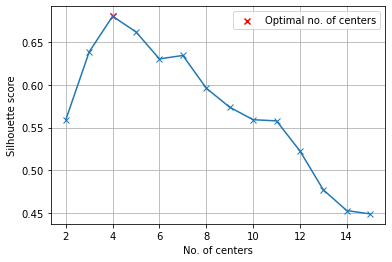

In [9]:
n_centers = np.arange(2, 16, 1)

centers = []
labels = []
silhouette_score = []
inertia = []

#Loop through different number of centers
for nc in n_centers:

    k_means_local = k_means(nc, 
                            'random', 
                            n_init = 50, 
                            max_iter = 100, 
                            verbose = True,
                            vectorise = True).fit(x, calculate_scores = True)
    
    centers.append(k_means_local.cluster_centers_)
    labels.append(k_means_local.predict(x))
    silhouette_score.append(k_means_local.silhouette_score)
    inertia.append(k_means_local.inertia_train_)

#Find optimal number of centers
pos_optimal = np.argmax(silhouette_score)
optimal_centers_kmeans = n_centers[pos_optimal]

#plotting
plt.figure()
plt.plot(n_centers, silhouette_score, marker = "x")
plt.xlabel("No. of centers")
plt.ylabel("Silhouette score")
plt.scatter(optimal_centers_kmeans, silhouette_score[pos_optimal], color = "r", marker = "x", label = "Optimal no. of centers")
plt.legend()
plt.grid()
plt.show()

### Visualise optimisation results and train best model

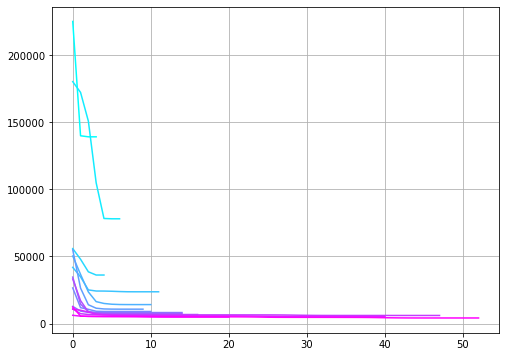

Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 42128.15656816252
Outer iteration 0: inertia: 41556.153148890866
Outer iteration 0: inertia: 40127.09799451846
Outer iteration 0: inertia: 37746.193798940876
Outer iteration 0: inertia: 36303.055671545706
Outer iteration 0: inertia: 36155.79269950072
Outer iteration 0: inertia: 36148.745886268785
Outer iteration 0: inertia: 36148.745886268785

 Beginning outer iteration 1...
Outer iteration 1: inertia: 142186.9980697402
Outer iteration 1: inertia: 94758.93261752797
Outer iteration 1: inertia: 83458.00001042939
Outer iteration 1: inertia: 71534.00860405125
Outer iteration 1: inertia: 69566.17652052487
Outer iteration 1: inertia: 68720.27243392632
Outer iteration 1: inertia: 68421.2028088303
Outer iteration 1: inertia: 68342.82735201402
Outer iteration 1: inertia: 68321.68940869631
Outer iteration 1: inertia: 68318.83692367183
Outer iteration 1: inertia: 68318.77621352326
Outer iteration 1: inertia: 68318.7

Outer iteration 30: inertia: 85505.79097529633
Outer iteration 30: inertia: 85505.43128136588
Outer iteration 30: inertia: 85505.350433988
Outer iteration 30: inertia: 85505.24907905576
Outer iteration 30: inertia: 85505.16347837554
Outer iteration 30: inertia: 85505.16347837554

 Beginning outer iteration 31...
Outer iteration 31: inertia: 94837.9465996735
Outer iteration 31: inertia: 80534.04141337752
Outer iteration 31: inertia: 70105.40639487226
Outer iteration 31: inertia: 68904.21899309327
Outer iteration 31: inertia: 68486.89487419381
Outer iteration 31: inertia: 68362.32610543231
Outer iteration 31: inertia: 68323.31766517664
Outer iteration 31: inertia: 68318.83692367183
Outer iteration 31: inertia: 68318.77621352326
Outer iteration 31: inertia: 68318.77621352326

 Beginning outer iteration 32...
Outer iteration 32: inertia: 135171.4411454015
Outer iteration 32: inertia: 80339.64985181659
Outer iteration 32: inertia: 77387.66330815543
Outer iteration 32: inertia: 77375.8731164

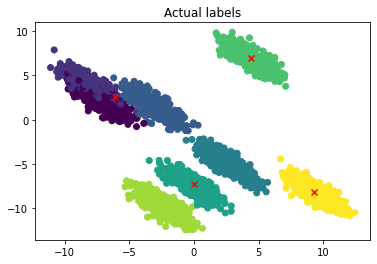

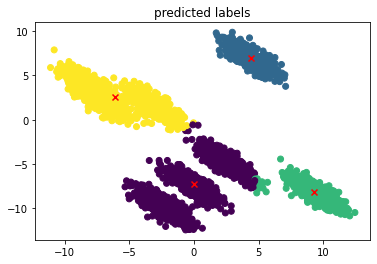

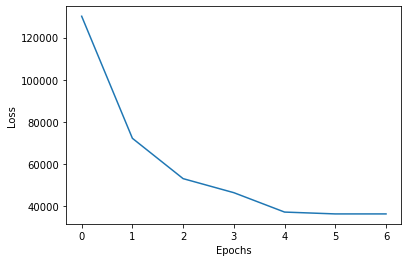

In [10]:
colors = plt.cm.cool(np.linspace(0, 1, len(n_centers)))

plt.figure(figsize = (8, 6))
for cnt, i in enumerate(n_centers):
    plt.plot(inertia[cnt], color = colors[cnt], label = str(i))
plt.grid()
plt.show()

#Fit the optimal model
k_means_optimal = k_means(optimal_centers_kmeans, 'random', 
                          n_init = 50, 
                          max_iter = 100, 
                          verbose = True).fit(x, calculate_scores = False)

labels_kmeans = k_means_optimal.predict(x)

plt.figure()
plt.title("Actual labels")
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.scatter(k_means_optimal.cluster_centers_[:, 0], k_means_optimal.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

plt.figure()
plt.title("predicted labels")
plt.scatter(x[:, 0], x[:, 1], c = labels_kmeans)
plt.scatter(k_means_optimal.cluster_centers_[:, 0], k_means_optimal.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

plt.figure()
plt.plot(k_means_optimal.inertia_train_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### K-means run - Sklearn implementation

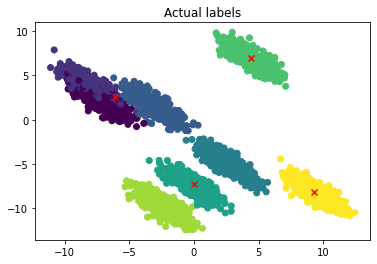

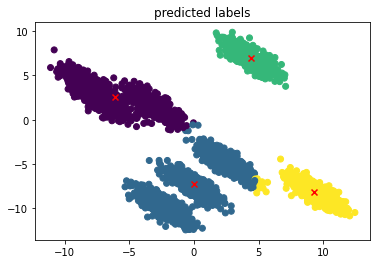

In [11]:
k_means_local = k_means_sklearn(optimal_centers_kmeans,
                                n_init = 50,
                                max_iter = 100)
k_means_local.fit(x)

labels_kmeans = k_means_local.predict(x)

plt.figure()
plt.title("Actual labels")
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.scatter(k_means_local.cluster_centers_[:, 0], k_means_local.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

plt.figure()
plt.title("predicted labels")
plt.scatter(x[:, 0], x[:, 1], c = labels_kmeans)
plt.scatter(k_means_local.cluster_centers_[:, 0], k_means_local.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

## GMM run

In [14]:
n_centers = np.arange(2, 16, 1)
covariance_type = "full"
training_loss = []
labels = []
silhouette_score = []
aic = []
bic = []

for nc in n_centers:
    test_gmm_run = gaussian_mixture_models(nc, 
                                           covariance_type = covariance_type, 
                                           random_state = 0, 
                                           verbose = True, 
                                           vectorise=True).fit(x, calculate_scores = True)
    
    labels_GMM = test_gmm_run.predict(x)
    
    training_loss.append(test_gmm_run.loss_train_)
    labels.append(labels_GMM)
    silhouette_score.append(test_gmm_run.silhouette_score)
    aic.append(test_gmm_run.aic_score)
    bic.append(test_gmm_run.bic_score)
    



Beginning GMM training...

Running k-means to initialise model parameters...
Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 226585.55885565255
Outer iteration 0: inertia: 222464.81323477137
Outer iteration 0: inertia: 212089.44833083506
Outer iteration 0: inertia: 181383.09192865004
Outer iteration 0: inertia: 145970.29349596938
Outer iteration 0: inertia: 139212.70185176015
Outer iteration 0: inertia: 139212.70185176015

 Beginning outer iteration 1...
Outer iteration 1: inertia: 139788.08136058852
Outer iteration 1: inertia: 139212.70185176015
Outer iteration 1: inertia: 139212.70185176015

 Beginning outer iteration 2...
Outer iteration 2: inertia: 277568.9423295859
Outer iteration 2: inertia: 177174.37575245657
Outer iteration 2: inertia: 139446.1807518388
Outer iteration 2: inertia: 139212.70185176015
Outer iteration 2: inertia: 139212.70185176015

 Beginning outer iteration 3...
Outer iteration 3: inertia: 263026.6553603084
Outer iteration 3: i

Calculating AIC...
Calculating BIC...

Beginning GMM training...

Running k-means to initialise model parameters...
Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 30067.917385005218
Outer iteration 0: inertia: 27055.701365314348
Outer iteration 0: inertia: 26581.50028602611
Outer iteration 0: inertia: 26472.37005077065
Outer iteration 0: inertia: 26442.43621025644
Outer iteration 0: inertia: 26438.59643552203
Outer iteration 0: inertia: 26438.42664212127
Outer iteration 0: inertia: 26438.42664212127

 Beginning outer iteration 1...
Outer iteration 1: inertia: 61179.77630300971
Outer iteration 1: inertia: 47227.26915895252
Outer iteration 1: inertia: 28035.947900103878
Outer iteration 1: inertia: 26591.579296112883
Outer iteration 1: inertia: 26449.42999882745
Outer iteration 1: inertia: 26438.59643552203
Outer iteration 1: inertia: 26438.426642121267
Outer iteration 1: inertia: 26438.426642121267

 Beginning outer iteration 2...
Outer iteration 2: ine

Outer iteration 4: inertia: 65574.1803797684
Outer iteration 4: inertia: 65393.43411347989
Outer iteration 4: inertia: 64652.12328032304
Outer iteration 4: inertia: 62176.64565572563
Outer iteration 4: inertia: 58146.12225334018
Outer iteration 4: inertia: 47233.65808603508
Outer iteration 4: inertia: 26482.69102003733
Outer iteration 4: inertia: 24827.53698828584
Outer iteration 4: inertia: 24709.009804242
Outer iteration 4: inertia: 24702.08730151917
Outer iteration 4: inertia: 24702.08730151917

 Beginning outer iteration 5...
Outer iteration 5: inertia: 53427.54349333617
Outer iteration 5: inertia: 31002.11445143626
Outer iteration 5: inertia: 15989.86270640161
Outer iteration 5: inertia: 15015.188031643436
Outer iteration 5: inertia: 14763.77737280944
Outer iteration 5: inertia: 14696.128164307936
Outer iteration 5: inertia: 14678.956637079107
Outer iteration 5: inertia: 14676.183155147086
Outer iteration 5: inertia: 14675.433340935006
Outer iteration 5: inertia: 14674.58549670324

Outer iteration 5: inertia: 25232.708823248027
Outer iteration 5: inertia: 24083.01512277314
Outer iteration 5: inertia: 23985.979403242764
Outer iteration 5: inertia: 23981.109002928646
Outer iteration 5: inertia: 23981.109002928646

 Beginning outer iteration 6...
Outer iteration 6: inertia: 79951.50898267335
Outer iteration 6: inertia: 69554.3367149625
Outer iteration 6: inertia: 66831.23890807206
Outer iteration 6: inertia: 64596.83306092931
Outer iteration 6: inertia: 60152.171313370796
Outer iteration 6: inertia: 45975.3754354822
Outer iteration 6: inertia: 27611.960308628288
Outer iteration 6: inertia: 24885.468385500626
Outer iteration 6: inertia: 24278.453220774678
Outer iteration 6: inertia: 24230.929662617284
Outer iteration 6: inertia: 24226.753153184065
Outer iteration 6: inertia: 24226.589871170734
Outer iteration 6: inertia: 24226.48356723736
Outer iteration 6: inertia: 24226.436876053896
Outer iteration 6: inertia: 24226.430860444667
Outer iteration 6: inertia: 24226.43

Calculating AIC...
Calculating BIC...

Beginning GMM training...

Running k-means to initialise model parameters...
Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 19328.60100430664
Outer iteration 0: inertia: 9370.280432204894
Outer iteration 0: inertia: 8926.189325152249
Outer iteration 0: inertia: 8551.83048319901
Outer iteration 0: inertia: 8352.659763310157
Outer iteration 0: inertia: 8299.967466114513
Outer iteration 0: inertia: 8280.16041437749
Outer iteration 0: inertia: 8267.3547999853
Outer iteration 0: inertia: 8261.373577678323
Outer iteration 0: inertia: 8257.838351210963
Outer iteration 0: inertia: 8256.15149205783
Outer iteration 0: inertia: 8255.4239680086
Outer iteration 0: inertia: 8255.26232773469
Outer iteration 0: inertia: 8255.26232773469

 Beginning outer iteration 1...
Outer iteration 1: inertia: 13475.769008246882
Outer iteration 1: inertia: 11623.24323737
Outer iteration 1: inertia: 11374.969925658825
Outer iteration 1: inerti


Finished GMM training!
Time to train: 0.5506 seconds
Converged: True
Calculating Silhouette score...
Calculating AIC...
Calculating BIC...

Beginning GMM training...

Running k-means to initialise model parameters...
Beginning K-means...

 Beginning outer iteration 0...
Outer iteration 0: inertia: 38165.09797748184
Outer iteration 0: inertia: 16072.627820837848
Outer iteration 0: inertia: 10626.41080330024
Outer iteration 0: inertia: 9291.512334519612
Outer iteration 0: inertia: 7988.492277563426
Outer iteration 0: inertia: 7784.861606280932
Outer iteration 0: inertia: 7757.088924886798
Outer iteration 0: inertia: 7748.859986300353
Outer iteration 0: inertia: 7745.773754735668
Outer iteration 0: inertia: 7745.403603741
Outer iteration 0: inertia: 7745.214083399532
Outer iteration 0: inertia: 7744.902856892008
Outer iteration 0: inertia: 7744.589276577068
Outer iteration 0: inertia: 7744.479930263871
Outer iteration 0: inertia: 7744.311008714763
Outer iteration 0: inertia: 7744.1130053

Outer iteration 7: inertia: 7463.791516856837
Outer iteration 7: inertia: 7463.775437363606
Outer iteration 7: inertia: 7463.741607792595
Outer iteration 7: inertia: 7463.721863082216
Outer iteration 7: inertia: 7463.713490086354
Outer iteration 7: inertia: 7463.713490086354

 Beginning outer iteration 8...
Outer iteration 8: inertia: 12733.920501257682
Outer iteration 8: inertia: 12058.870306328421
Outer iteration 8: inertia: 11961.793428628183
Outer iteration 8: inertia: 11906.571663898552
Outer iteration 8: inertia: 11822.875331725561
Outer iteration 8: inertia: 11635.680254138537
Outer iteration 8: inertia: 11440.247697711387
Outer iteration 8: inertia: 11378.400150910164
Outer iteration 8: inertia: 11371.145948117604
Outer iteration 8: inertia: 11370.346276523906
Outer iteration 8: inertia: 11370.076154521867
Outer iteration 8: inertia: 11369.901399103655
Outer iteration 8: inertia: 11369.736130114594
Outer iteration 8: inertia: 11369.650583574523
Outer iteration 8: inertia: 11369

Outer iteration 7: inertia: 20922.969230577546
Outer iteration 7: inertia: 8335.728868625923
Outer iteration 7: inertia: 7037.608959392974
Outer iteration 7: inertia: 6839.1255160865785
Outer iteration 7: inertia: 6778.833138771994
Outer iteration 7: inertia: 6753.668771586603
Outer iteration 7: inertia: 6742.047871392982
Outer iteration 7: inertia: 6737.173449277032
Outer iteration 7: inertia: 6734.019814574985
Outer iteration 7: inertia: 6733.167193975314
Outer iteration 7: inertia: 6732.992198870729
Outer iteration 7: inertia: 6732.856109184307
Outer iteration 7: inertia: 6732.769217302923
Outer iteration 7: inertia: 6732.741924438644
Outer iteration 7: inertia: 6732.728658372892
Outer iteration 7: inertia: 6732.728658372892

 Beginning outer iteration 8...
Outer iteration 8: inertia: 16615.044951504125
Outer iteration 8: inertia: 8644.139050249754
Outer iteration 8: inertia: 7742.635336405483
Outer iteration 8: inertia: 7570.301381670432
Outer iteration 8: inertia: 7477.92739827573

Outer iteration 5: inertia: 6580.77889029437
Outer iteration 5: inertia: 6425.870073767942
Outer iteration 5: inertia: 6362.833446705737
Outer iteration 5: inertia: 6342.676494867832
Outer iteration 5: inertia: 6333.7646031304885
Outer iteration 5: inertia: 6326.391795495003
Outer iteration 5: inertia: 6320.912751450555
Outer iteration 5: inertia: 6315.093760219477
Outer iteration 5: inertia: 6311.003314658511
Outer iteration 5: inertia: 6307.870119889945
Outer iteration 5: inertia: 6305.395907472489
Outer iteration 5: inertia: 6304.067691531566
Outer iteration 5: inertia: 6303.12532105795
Outer iteration 5: inertia: 6302.9152653182255
Outer iteration 5: inertia: 6302.720940270046
Outer iteration 5: inertia: 6302.528402631621
Outer iteration 5: inertia: 6302.465776303875
Outer iteration 5: inertia: 6302.465776303875

 Beginning outer iteration 6...
Outer iteration 6: inertia: 10232.73267900327
Outer iteration 6: inertia: 8572.843660005266
Outer iteration 6: inertia: 7552.13740011645
Ou

Outer iteration 2: inertia: 7864.814372355296
Outer iteration 2: inertia: 7629.508469762606
Outer iteration 2: inertia: 7540.559816977218
Outer iteration 2: inertia: 7487.0706630768245
Outer iteration 2: inertia: 7458.6399563270925
Outer iteration 2: inertia: 7449.095042627673
Outer iteration 2: inertia: 7444.778019420543
Outer iteration 2: inertia: 7442.430972105303
Outer iteration 2: inertia: 7439.591406715335
Outer iteration 2: inertia: 7436.988780135504
Outer iteration 2: inertia: 7436.2461594553115
Outer iteration 2: inertia: 7435.732599962925
Outer iteration 2: inertia: 7435.236223451083
Outer iteration 2: inertia: 7434.758465734163
Outer iteration 2: inertia: 7434.459482139851
Outer iteration 2: inertia: 7434.161879169308
Outer iteration 2: inertia: 7433.822581119944
Outer iteration 2: inertia: 7433.639284540871
Outer iteration 2: inertia: 7433.536829718421
Outer iteration 2: inertia: 7433.368071206655
Outer iteration 2: inertia: 7433.2136426116285
Outer iteration 2: inertia: 74

Outer iteration 9: inertia: 6655.803804500092
Outer iteration 9: inertia: 6649.865295333902
Outer iteration 9: inertia: 6644.794621936936
Outer iteration 9: inertia: 6638.957714393907
Outer iteration 9: inertia: 6634.472554629645
Outer iteration 9: inertia: 6631.539213357774
Outer iteration 9: inertia: 6629.94572645652
Outer iteration 9: inertia: 6628.195712739802
Outer iteration 9: inertia: 6627.407733399821
Outer iteration 9: inertia: 6626.991176506649
Outer iteration 9: inertia: 6626.167923708403
Outer iteration 9: inertia: 6625.472868471252
Outer iteration 9: inertia: 6624.729472727533
Outer iteration 9: inertia: 6624.300580030903
Outer iteration 9: inertia: 6624.201236179115
Outer iteration 9: inertia: 6624.146310959293
Outer iteration 9: inertia: 6624.123787615669
Outer iteration 9: inertia: 6624.116253367959
Outer iteration 9: inertia: 6624.110351708518
Outer iteration 9: inertia: 6624.110351708518

 Finished Training! Automatically selecting optimal centers...

Finished k-means

C:\Users\ryanb.LAPTOP-4EHB9TVB\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ryanb.LAPTOP-4EHB9TVB\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Outer iteration 4: inertia: 5924.4531162604335
Outer iteration 4: inertia: 5923.601726033114
Outer iteration 4: inertia: 5923.4208105217585
Outer iteration 4: inertia: 5923.26418049943
Outer iteration 4: inertia: 5923.142652144694
Outer iteration 4: inertia: 5923.04464195684
Outer iteration 4: inertia: 5922.989282382427
Outer iteration 4: inertia: 5922.922735300832
Outer iteration 4: inertia: 5922.875865595587
Outer iteration 4: inertia: 5922.875865595587

 Beginning outer iteration 5...
Outer iteration 5: inertia: 8960.45508158229
Outer iteration 5: inertia: 6536.779160944731
Outer iteration 5: inertia: 6396.654187303878
Outer iteration 5: inertia: 6344.856822866959
Outer iteration 5: inertia: 6323.243426289288
Outer iteration 5: inertia: 6313.93013112233
Outer iteration 5: inertia: 6306.008717739184
Outer iteration 5: inertia: 6300.348043012521
Outer iteration 5: inertia: 6296.384330280045
Outer iteration 5: inertia: 6292.984530440312
Outer iteration 5: inertia: 6291.532653003874
Out

Outer iteration 1: inertia: 5149.065817786415
Outer iteration 1: inertia: 5149.065817786415

 Beginning outer iteration 2...
Outer iteration 2: inertia: 14187.74204437279
Outer iteration 2: inertia: 6370.273150918115
Outer iteration 2: inertia: 5892.214036676199
Outer iteration 2: inertia: 5864.761588561711
Outer iteration 2: inertia: 5851.460428188063
Outer iteration 2: inertia: 5845.420855664835
Outer iteration 2: inertia: 5841.4994366557485
Outer iteration 2: inertia: 5838.507112855609
Outer iteration 2: inertia: 5835.089865982578
Outer iteration 2: inertia: 5832.074483272383
Outer iteration 2: inertia: 5830.774475143977
Outer iteration 2: inertia: 5829.869769424306
Outer iteration 2: inertia: 5829.590885126105
Outer iteration 2: inertia: 5829.509368234509
Outer iteration 2: inertia: 5829.4689702852265
Outer iteration 2: inertia: 5829.4689702852265

 Beginning outer iteration 3...
Outer iteration 3: inertia: 19743.424873810745
Outer iteration 3: inertia: 7375.177409753626
Outer iter


Loss at epoch 3: -4.3142774527534735
Tolerance: 0.0016962246027576455

Loss at epoch 4: -4.3132079223805
Tolerance: 0.0010695303729733041

Loss at epoch 5: -4.312479073916978
Tolerance: 0.0007288484635221693

Finished GMM training!
Time to train: 0.9790 seconds
Converged: True
Calculating Silhouette score...
Calculating AIC...
Calculating BIC...


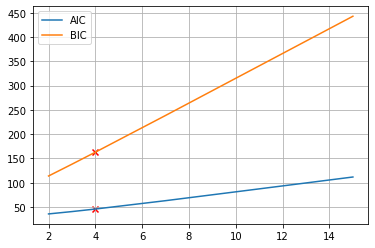

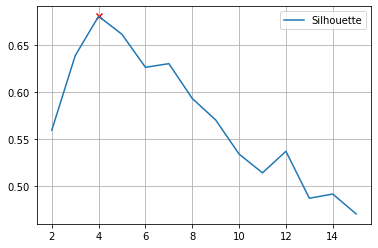

4


In [15]:
#Find optimal number of centers
pos_optimal = np.argmax(silhouette_score)
optimal_centers_GMM = n_centers[pos_optimal]    

plt.figure()
plt.plot(n_centers, aic, label = "AIC")
plt.plot(n_centers, bic, label = "BIC")
plt.scatter(optimal_centers_GMM, aic[pos_optimal], color = "r", marker = "x")
plt.scatter(optimal_centers_GMM, bic[pos_optimal], color = "r", marker = "x")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(n_centers, silhouette_score, label = "Silhouette")
plt.scatter(optimal_centers_GMM, silhouette_score[pos_optimal], color = "r", marker = "x")
plt.legend()
plt.grid()
plt.show()

nc_GMM = optimal_centers_GMM

print(nc_GMM)

### Visualise optimisation results and train best model

Finished in: 0.091 seconds


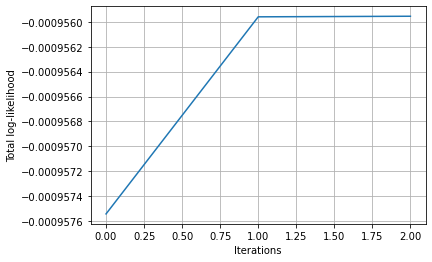

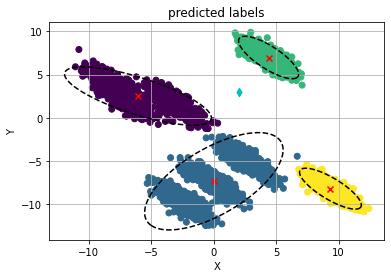

[2525 1289  638 5548]


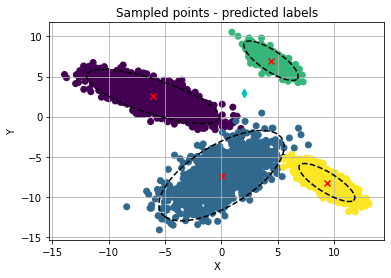

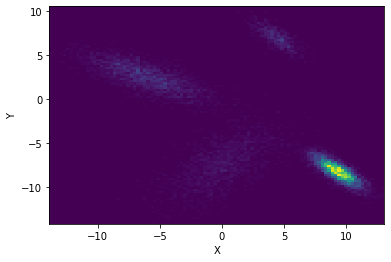

In [16]:
#Visualise all 
t0 = time.time()
optimal_model = gaussian_mixture_models(nc_GMM, 
                                        covariance_type = covariance_type, 
                                        use_sklearn = True,
                                        random_state = 0, 
                                        verbose = False, 
                                        vectorise = True).fit(x, False)

print("Finished in: {:.3f} seconds".format(time.time() - t0))

labels_GMM = optimal_model.predict(x)
weights_GMM, means_GMM, covariances_GMM = optimal_model.get_params()

plt.figure()
plt.plot(np.array(optimal_model.loss_train_) / x.shape[0])
plt.ylabel("Total log-likelihood")
plt.xlabel("Iterations")
plt.grid()
plt.show()

query = np.array([[2, 3]])

resp = optimal_model.posterior_likelihood(query.T)

plt.figure()
plt.title("predicted labels")
plt.scatter(x[:, 0], x[:, 1], c = labels_GMM)
plt.scatter(means_GMM[:, 0], means_GMM[:, 1], c = "r", marker = "x")
plt.scatter(query[0, 0], query[0, 1], c = "c", marker = "d")

for k in range(nc_GMM):
    ellipse = plot_ellipse(means_GMM[k, :], covariances_GMM[k, :, :], X2_critical = 5.991)
    plt.plot(ellipse[:, 0], ellipse[:, 1], "k--")

plt.xlabel("X")
plt.ylabel("Y")
plt.grid()    
plt.show()

x_sample, label_sample = optimal_model.sample(10000)

plt.figure()
plt.title("Sampled points - predicted labels")
plt.scatter(x_sample[:, 0], x_sample[:, 1], c = label_sample)
plt.scatter(means_GMM[:, 0], means_GMM[:, 1], c = "r", marker = "x")
plt.scatter(query[0, 0], query[0, 1], c = "c", marker = "d")

for k in range(nc_GMM):
    ellipse = plot_ellipse(means_GMM[k, :], covariances_GMM[k, :, :], X2_critical = 5.991)
    plt.plot(ellipse[:, 0], ellipse[:, 1], "k--")

plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.show()

plt.figure()
plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins = 100)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Visualise NLL on data space

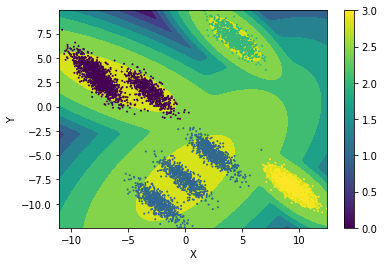

In [17]:
X, Y = np.meshgrid(np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100), np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), 100))

XY = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
Z = []

p_x, ll, ll_sum = optimal_model.data_likelihood(XY)

plt.figure()
plt.contourf(X, Y, ll_sum.reshape(100, 100))
plt.scatter(x[:, 0], x[:, 1], c = labels_GMM, s = 1)
plt.colorbar()
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Compare to Scikit learn version

Finished in: 0.030 seconds


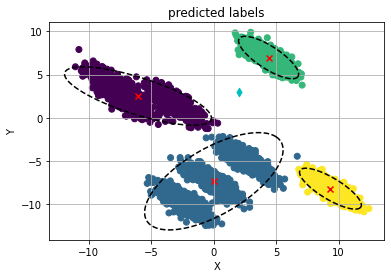

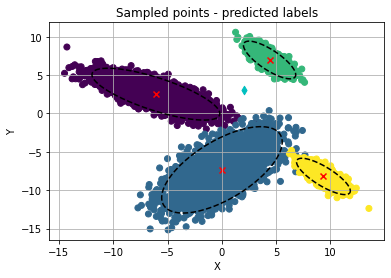

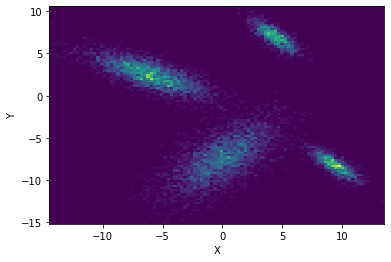

In [18]:
from sklearn.mixture import GaussianMixture

t0 = time.time()
gm = GaussianMixture(n_components=nc_GMM, random_state=0, covariance_type = covariance_type).fit(x)
print("Finished in: {:.3f} seconds".format(time.time() - t0))

gm_labels = gm.predict(x)

plt.figure()
plt.title("predicted labels")
plt.scatter(x[:, 0], x[:, 1], c = gm_labels)
plt.scatter(gm.means_[:, 0], gm.means_[:, 1], c = "r", marker = "x")
plt.scatter(query[0, 0], query[0, 1], c = "c", marker = "d")

for k in range(nc_GMM):
    ellipse = plot_ellipse(gm.means_[k, :], gm.covariances_[k, :, :], X2_critical = 5.991, pca_method = False)
    plt.plot(ellipse[:, 0], ellipse[:, 1], "k--")

plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.show()

x_sample, label_sample = gm.sample(10000)

plt.figure()
plt.title("Sampled points - predicted labels")
plt.scatter(x_sample[:, 0], x_sample[:, 1], c = label_sample)
plt.scatter(gm.means_[:, 0], gm.means_[:, 1], c = "r", marker = "x")
plt.scatter(query[0, 0], query[0, 1], c = "c", marker = "d")

for k in range(nc_GMM):
    ellipse = plot_ellipse(gm.means_[k, :], gm.covariances_[k, :, :], X2_critical = 5.991, pca_method = False)
    plt.plot(ellipse[:, 0], ellipse[:, 1], "k--")
    
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.show()

plt.figure()
plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins = 100)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Compare results

In [19]:
print(gm.lower_bound_, optimal_model.lower_bound_)

print(gm.weights_, "\n")
print(optimal_model.weights_, "\n")

print(gm.means_, "\n")
print(optimal_model.means_, "\n")

print(gm.covariances_, "\n")
print(optimal_model.covariances_, "\n")

-4.779773410687999 -4.779773410650239
[0.36708256 0.37913649 0.12719984 0.12658111] 

[0.36707752 0.37913906 0.12719984 0.12658359] 

[[-6.06934023  2.51434447]
 [ 0.01055357 -7.34901337]
 [ 4.39695411  6.96719813]
 [ 9.35343    -8.2055345 ]] 

[[-6.06942926  2.51441141]
 [ 0.01051454 -7.34895246]
 [ 4.39695406  6.96719819]
 [ 9.35337934 -8.20550087]] 

[[[ 5.78281895 -2.49258222]
  [-2.49258222  1.90638672]]

 [[ 5.13800696  3.35660277]
  [ 3.35660277  5.28758237]]

 [[ 0.96664863 -0.77287734]
  [-0.77287734  1.00773232]]

 [[ 1.02465885 -0.7822991 ]
  [-0.7822991   0.93640518]]] 

[[[ 5.78231468 -2.49218056]
  [-2.49218056  1.90608265]]

 [[ 5.13767632  3.35656607]
  [ 3.35656607  5.28787196]]

 [[ 0.96664752 -0.77287721]
  [-0.77287721  1.00773117]]

 [[ 1.02477778 -0.78236824]
  [-0.78236824  0.93645733]]] 



### Multivariate dataset

(10000, 50) (10000,) (10, 50)


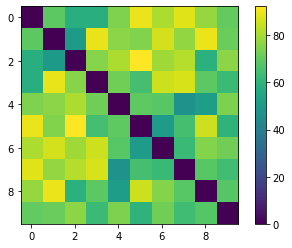

In [20]:
from sklearn.datasets import make_blobs
n_features = 50
n_centers = 10
X, y, centers = make_blobs(n_samples = 10000,
                  n_features = n_features,
                  centers = n_centers,
                  cluster_std = 1,
                  center_box = (-10, 10),
                  shuffle = True,
                  return_centers = True) #Turn this off to only expect 2 outputs

print(X.shape, y.shape, centers.shape)

center_distance_matrix = np.zeros((n_centers, n_centers))

for i in range(n_centers):
    for j in range(n_centers):
        
        center_distance_matrix[i, j] = np.sum((centers[i, :] - centers[j, :])**2) / n_features
        
plt.figure()
plt.imshow(center_distance_matrix)
plt.colorbar()
plt.show()

In [21]:
t0 = time.time()
optimal_model = gaussian_mixture_models(10, 
                                        covariance_type = "full", 
                                        use_sklearn = True,
                                        random_state = 0, 
                                        verbose = False, 
                                        vectorise = True,
                                        n_init = 10,
                                        tol = 1e-4).fit(X, False)

print("Finished in: {:.3f} seconds".format(time.time() - t0))

Finished in: 17.541 seconds


In [22]:
from sklearn.mixture import GaussianMixture

t0 = time.time()
gm = GaussianMixture(n_components=10, 
                     random_state=0, 
                     covariance_type = "full",
                     n_init=10, 
                     tol=1e-4, 
                     verbose = False, 
                     verbose_interval = 1).fit(X)

print("Finished in: {:.3f} seconds".format(time.time() - t0))

Finished in: 3.147 seconds


In [23]:
print(optimal_model.n_iter_, gm.n_iter_)

print(optimal_model.lower_bound_, gm.lower_bound_)

print("Best lower bound:", ["Mine", "Sklearns"][np.argmax([optimal_model.lower_bound_, gm.lower_bound_])])

print(optimal_model.weights_, "\n\n", gm.weights_, "\n\n")

print(optimal_model.means_, "\n\n", gm.means_)

1 2
-72.65713941360225 -72.6571394136168
Best lower bound: Mine
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 

 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 


[[-4.00712047e+00  2.77679751e+00  6.43272379e-01 -4.79047647e+00
   3.12514833e+00 -7.32751045e+00  1.46474271e+00  6.70490602e+00
   5.34490266e+00 -2.33251243e+00  2.85267118e-03 -5.11392046e+00
   8.31758731e-01 -5.67944117e+00  1.90898146e+00  2.30812301e+00
   6.80251130e+00  1.31614882e+00 -9.53930878e+00 -6.48179788e+00
   6.64690391e+00 -2.66858277e+00 -1.79891508e-01  3.87402837e+00
   8.95511584e+00 -4.39032274e-01  5.29099083e+00  3.20716424e+00
  -7.08694200e+00 -5.17814018e-01 -8.89421659e+00 -7.49406221e+00
   8.48020936e+00  5.19177866e+00  4.87926752e+00  3.07219488e+00
   4.51023429e+00 -4.24235337e+00  8.24214111e+00  8.01516403e+00
  -6.05805440e+00  9.26992826e+00 -5.97146676e+00 -8.63513275e+00
   8.70081121e+00  4.26556623e+00  9.15480245e-02  8.96575992e+00
  -7.80005540e+00  9.73729619e+00]
 [ 1.85655959e+00 -